In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.functions import *
from pyspark.mllib.stat import Statistics
from pyspark.sql.types import IntegerType, DoubleType, BooleanType, StringType, TimestampType


from pyspark.ml.feature import VectorAssembler,StandardScaler
#from pyspark.mllib.feature import StandardScaler 

spark = SparkSession.Builder().appName('DDAM_Project_north').getOrCreate()
sqlCtx = SQLContext(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/16 20:42:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [2]:
df = spark.read.options(inferSchema = True, delimiter = ',', header = True).csv('../../Datasets/North_Incidents_Cleaned.csv')

In [3]:
df.count()

83267

In [4]:
df.show()

23/12/16 20:43:13 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+-------------------+------------------+------------------+------------------+----------+-------+-----+-------------+------------+-------------+-------------+--------------+--------------+----------------+-------+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+-----+---------------+----+------+---------------+---------------------+-----------------+
|Severity|         Start_Time|         Start_Lat|         Start_Lng|       Distance_mi|      City| County|State|Temperature_F|Wind_Chill_F|Humidity_perc|Visibility_mi|Wind_Direction|Wind_Speed_mph|Precipitation_in|Amenity|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station| Stop|Traffic_Calming|Traffic_Signal|month|day_of_the_week|hour|season|Working_Weekend|Astronomical_Twilight|Weather_Condition|
+--------+-------------------+------------------+------------------+------------------+----------+-------+-----+-------------+------------+-------------+-------------+---------

BOXPLOTS

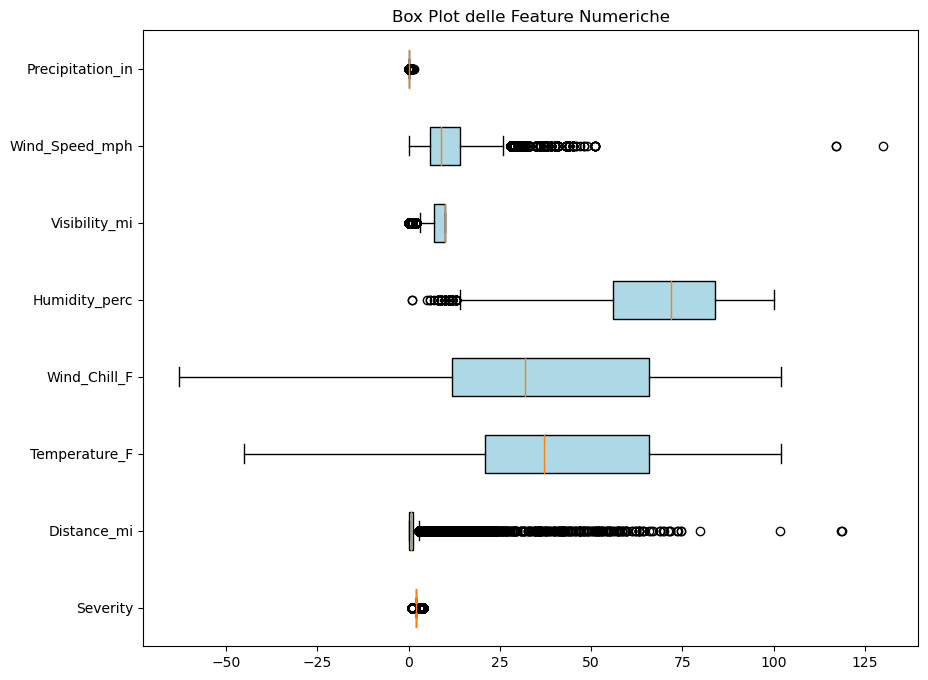

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

numerical_features = ['Severity', 'Distance_mi', 'Temperature_F', 'Wind_Chill_F', 'Humidity_perc', 'Visibility_mi', 'Wind_Speed_mph', 'Precipitation_in']
df_numerical = df.select(numerical_features).na.drop()
df_numerical_pd = df_numerical.toPandas()
plt.figure(figsize=(10, 8))
plt.boxplot(df_numerical_pd.values, vert=False, labels=numerical_features, patch_artist=True, boxprops=dict(facecolor="lightblue"))

plt.title("Box Plot delle Feature Numeriche")
plt.show()


Pearson and Spearman correlation

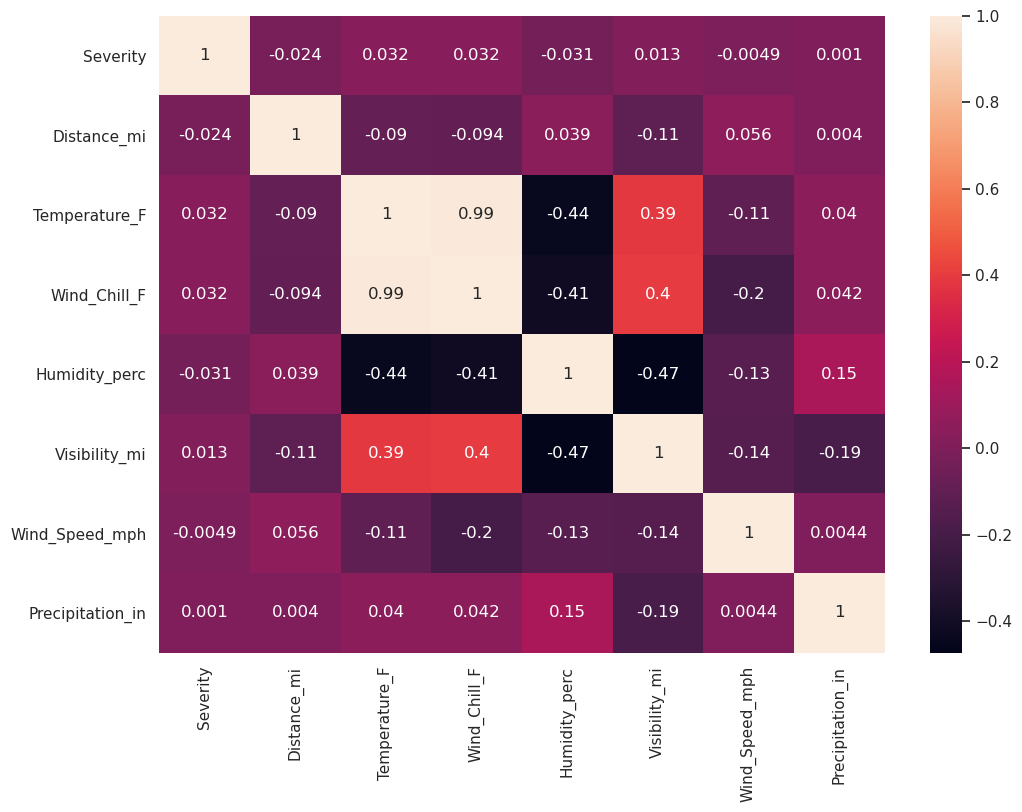

In [6]:
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import corr

numerical_features = ['Severity', 'Distance_mi', 'Temperature_F', 'Wind_Chill_F', 'Humidity_perc', 'Visibility_mi', 'Wind_Speed_mph', 'Precipitation_in']
correlationDF = df.select(numerical_features).toPandas().corr()
sns.set(rc={'figure.figsize': (11.7, 8.27)})
sns.heatmap(correlationDF, annot=True)
plt.show()


In [7]:
df=df.drop('Wind_Chill_F')

In [8]:
# Drop Wind_Chill because  correlated with Temperature 0.99 and  more correlated with other feature then Temperature

df = df.drop('Wind_Chill_F')

In [9]:
cols=['Distance_mi', 'Temperature_F', 'Humidity_perc', 'Visibility_mi', 'Wind_Speed_mph', 'Precipitation_in']

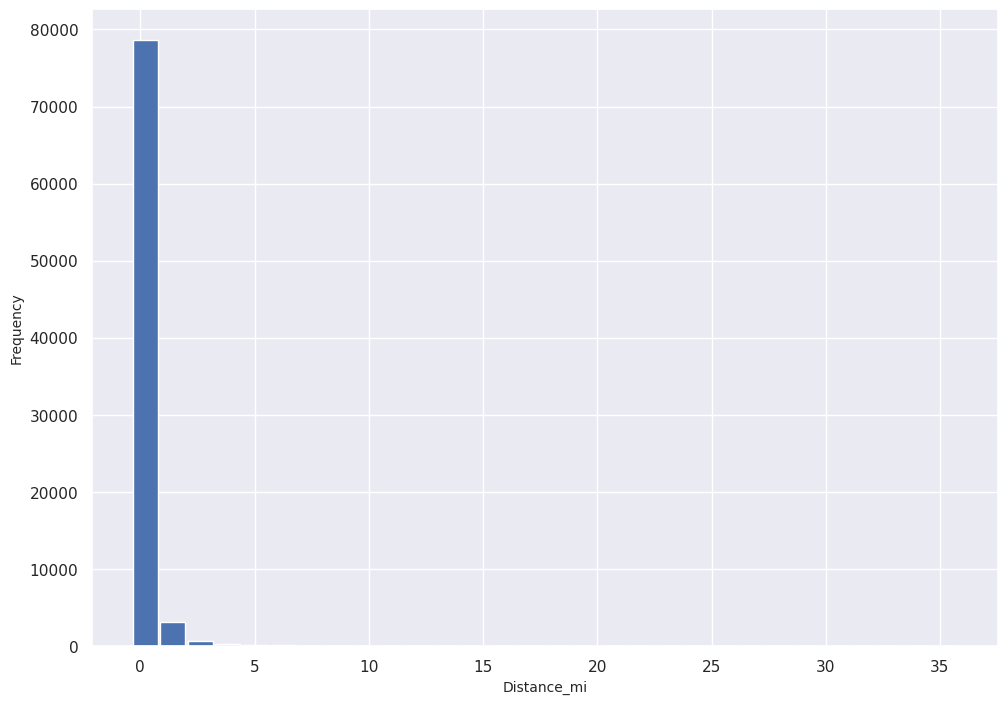

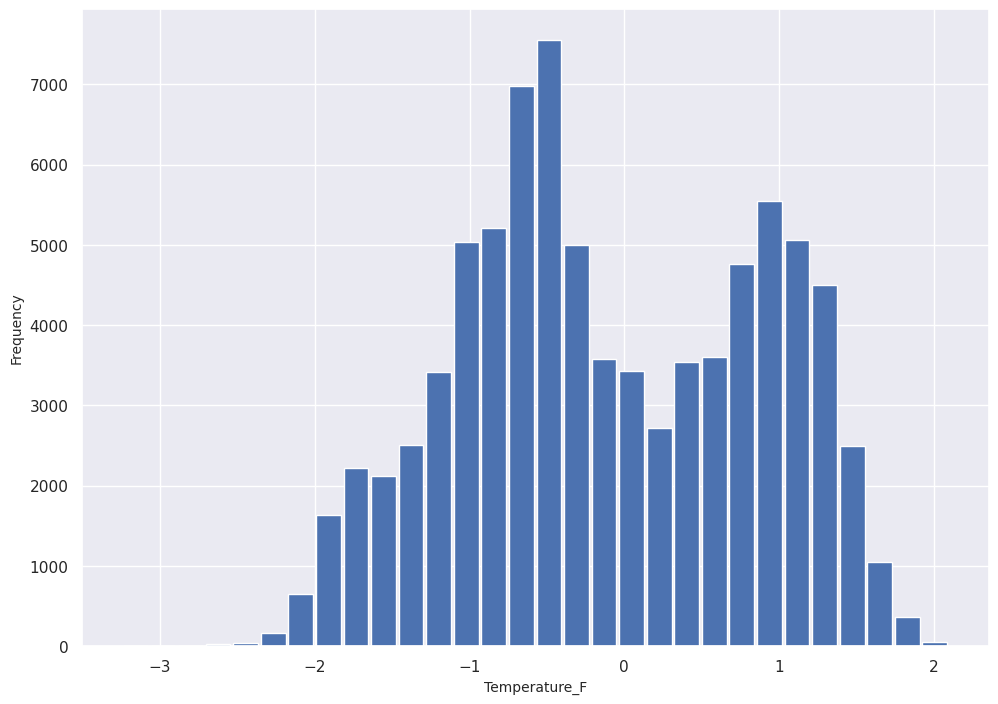

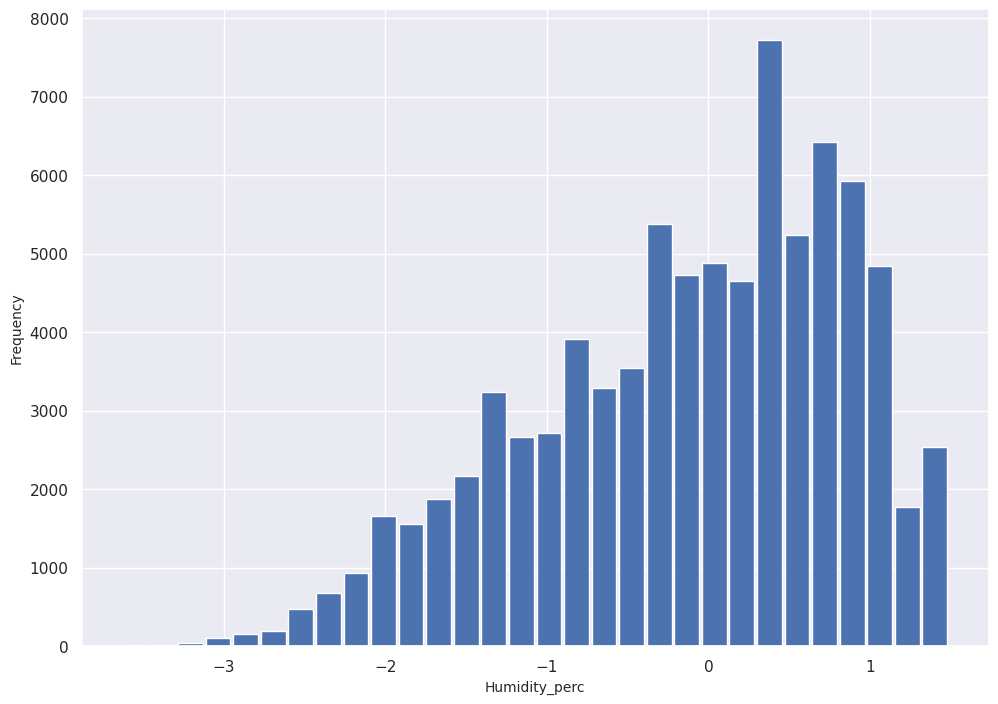

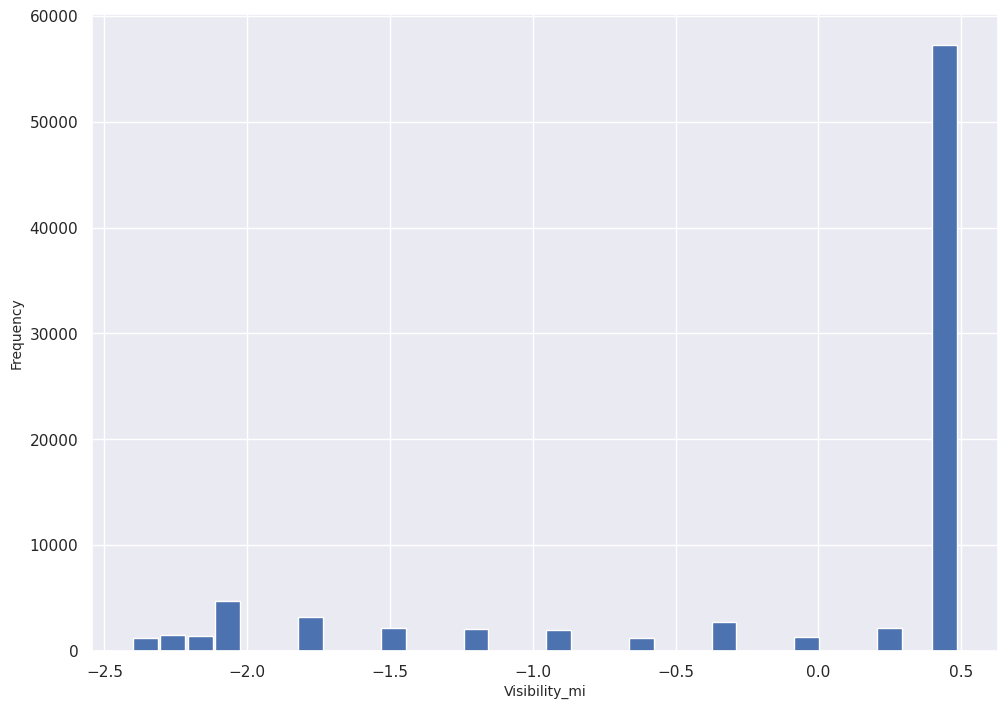

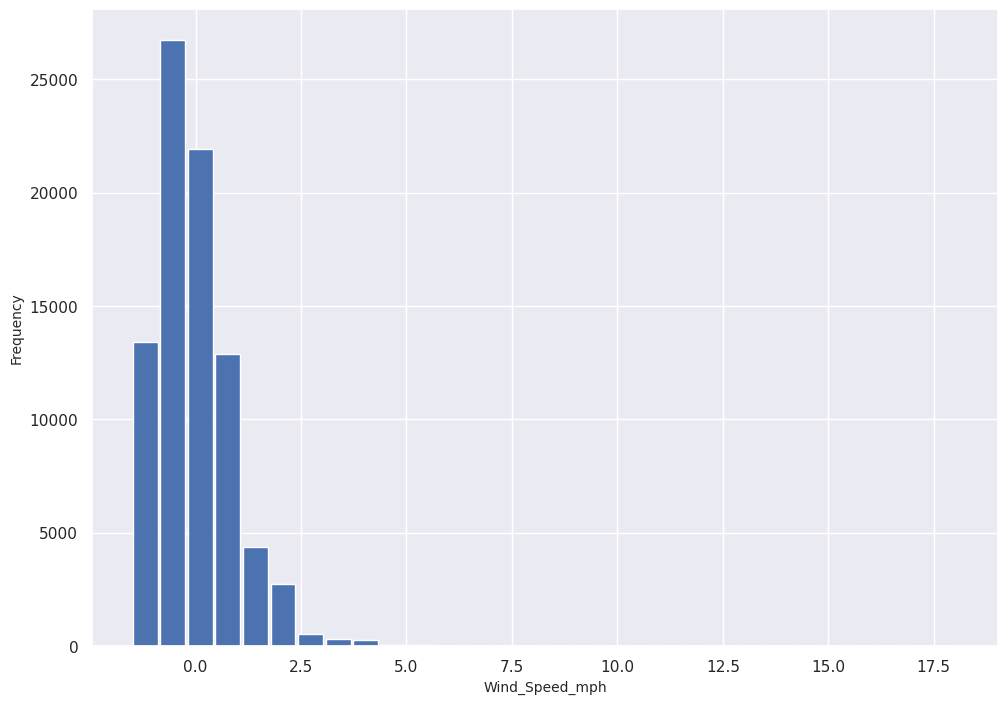

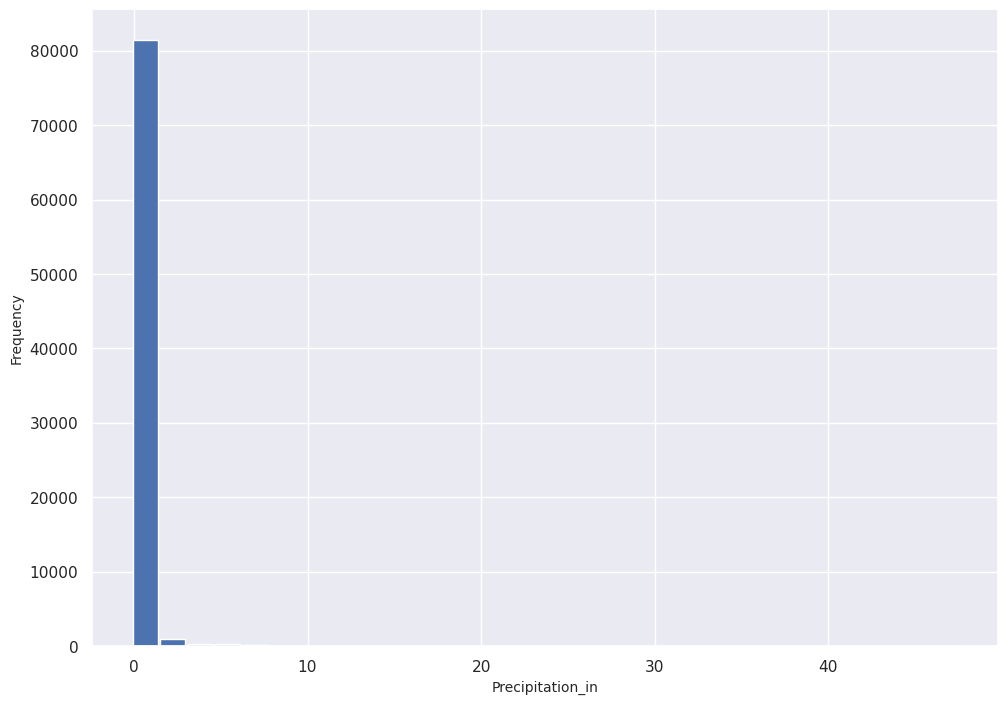

In [10]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

assembler = VectorAssembler(inputCols=cols, outputCol="features")
assembled_df = assembler.transform(df)
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
# Calcola la media e la deviazione standard
scaler_model = scaler.fit(assembled_df)
# Applica lo StandardScaler al DataFrame
scaled_df = scaler_model.transform(assembled_df)
scaled_df.createOrReplaceTempView("Incidents_Data")
query = spark.sql('SELECT scaled_features FROM Incidents_Data') 
i=0
for col in cols:
    h = query.select('scaled_features').rdd.map(lambda x: x[0][i]).histogram(30)
    dfh = pd.DataFrame(
        list(zip(*h)), 
        columns=['bin', 'frequency']
    )
    # estraggo dai dal dataframe pandas per ottenere i bin e le frequenze necessari per il plotting
    bins = dfh['bin']
    counts = dfh['frequency']
    #  classic pandas syntax
    plt.hist(bins, len(bins), weights=counts, rwidth=0.9)
    plt.xlabel(f'{col}', size=10)
    plt.ylabel("Frequency", size=10)
    #plt.grid(True) 
    plt.show()
    i+=1

conta outliers

In [11]:
scaled_df.createOrReplaceTempView("outliers") 
query = sqlCtx.sql("Select scaled_features from outliers o")
#query.show()
i=0
xy_columns = ['Distance_mi', 'Temperature_F', 'Humidity_perc', 'Visibility_mi', 'Wind_Speed_mph', 'Precipitation_in']
range_=[(-1,4),(-3,2),(-3,2),(-3,1),(-2,4),(-1,5)]
i=0
for col in xy_columns: 
    h = query.select('scaled_features').rdd.map(lambda x: x[0][i])
    even_numbers = h.filter(lambda x: x>range_[i][1] or x<range_[i][0])
    print(even_numbers.count(),'è la colonna',col)
    i+=1

649 è la colonna Distance_mi


193 è la colonna Temperature_F


97 è la colonna Humidity_perc


0 è la colonna Visibility_mi


291 è la colonna Wind_Speed_mph


456 è la colonna Precipitation_in


BOXPLOTS 2

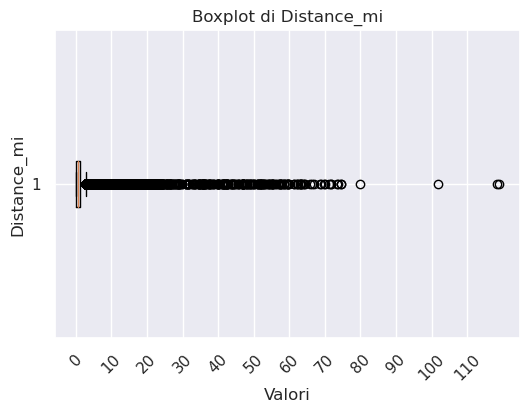

In [ ]:
cols=['Distance_mi', 'Temperature_F', 'Humidity_perc', 'Visibility_mi', 'Wind_Speed_mph', 'Precipitation_in']
df.createOrReplaceTempView("df")
outliers_list=[]
for col in cols: 
    df_filtered = df.filter(df[col].isNotNull())
    percentiles = df_filtered.approxQuantile(col, [0.25, 0.5, 0.75], 0.01)
    Q1, median, Q3 = percentiles
    IQR=Q3-Q1
    W1=Q1-1.5*IQR
    W3=Q3+1.5*IQR
    query=""" SELECT """+ col + """ FROM df WHERE """ + col + """<""" + str(W1) +""" OR """+ col + """>""" + str(W3)
    outliers=sqlCtx.sql(query)
    numero_outliers=outliers.count()
    outliers_list.append(['Numero outlier per '+ col+' '+str(numero_outliers)])
    min_Query=""" SELECT MIN("""+col+""") AS Min FROM df """
    min_=sqlCtx.sql(min_Query)
    min_=min_.select('Min').rdd.flatMap(lambda x: x).collect()[0]
    max_Query=""" SELECT MAX("""+col+""") AS Max FROM df """
    max_=sqlCtx.sql(max_Query)
    max_=max_.select('Max').rdd.flatMap(lambda x: x).collect()[0]
    plt.figure(figsize=(6, 4))
    plt.boxplot([df_filtered.select(col).rdd.flatMap(lambda x: x).collect()], vert=False)
    plt.title('Boxplot di {}'.format(col))
    plt.xlabel('Valori')
    plt.ylabel('{}'.format(col))
    #plt.xticks([W1, Q1, median, Q3,W3], ['W1', 'Q1', 'Median', 'Q3', 'W3'])
    plt.xticks(range(int(min_),int(max_)+1,10), rotation=45)
    plt.show()
print(outliers_list)

# CLUSTERING

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SQLContext, SparkSession, Row
from pyspark.sql.functions import *
from pyspark.mllib.stat import Statistics
from pyspark.sql.types import IntegerType, DoubleType, BooleanType, StringType, TimestampType
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, StandardScaler
import plotly.express as px

from pyspark.mllib.clustering import BisectingKMeans as BM
from pyspark.mllib.clustering import BisectingKMeansModel
from pyspark.ml.clustering import BisectingKMeans

In [89]:
df_cluster=df
df_cluster.count()

83267

Normalization

In [90]:
col = ['Start_Lat','Start_Lng','Distance_mi','Temperature_F','Humidity_perc','Visibility_mi','Wind_Speed_mph','Precipitation_in']

assembler = VectorAssembler(
    inputCols=col,
    outputCol="features")

output_dataset = assembler.transform(df_cluster)

scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")

output_dataset = scaler.fit(output_dataset).transform(output_dataset)

clusteringData = output_dataset.select("features_scaled", "Severity")

clusteringData.show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------+--------+
|features_scaled                                                                                                                                   |Severity|
+--------------------------------------------------------------------------------------------------------------------------------------------------+--------+
|[0.019999311764017622,0.8910088209453775,0.0,0.5102040816326531,0.6363636363636365,1.0,0.1,0.0]                                                   |3       |
|[0.020788663289338972,0.8912898875255447,0.005443745162050281,0.5102040816326531,0.6363636363636365,1.0,0.1,0.0]                                  |2       |
|[0.02078995726054547,0.8912897865506415,0.007799616329552722,0.5102040816326531,0.6363636363636365,1.0,0.07692307692307693,0.0]                   |2       |
|[0.020788663289338972,0.8912898875255447,0.00544374

In [91]:
to_drop=['Start_Time','City','County','Wind_Direction','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal','hour','month']
df_cluster=df_cluster.drop(*to_drop) # con asterisco passo gli elementi singoli al metodo drop
df_cluster.show()

+--------+------------------+------------------+------------------+-----+-------------+-------------+-------------+--------------+----------------+---------------+------+---------------+---------------------+-----------------+
|Severity|         Start_Lat|         Start_Lng|       Distance_mi|State|Temperature_F|Humidity_perc|Visibility_mi|Wind_Speed_mph|Precipitation_in|day_of_the_week|season|Working_Weekend|Astronomical_Twilight|Weather_Condition|
+--------+------------------+------------------+------------------+-----+-------------+-------------+-------------+--------------+----------------+---------------+------+---------------+---------------------+-----------------+
|       3|         41.877678|        -86.088089|               0.0|   MI|         30.0|         64.0|         10.0|          13.0|             0.0|        Tuesday|Winter|     WorkingDay|                  Day|           Normal|
|       2|41.883412599363886|-86.07864260632476|             0.647|   MI|         30.0|     

K-Means with k in range[2-30]

************************************************



Results for K = 2
Silhouette with squared euclidean distance: 0.6136
SSE (Sum of Squared Errors): 16011.83966687126
************************************************



Results for K = 3
Silhouette with squared euclidean distance: 0.6101
SSE (Sum of Squared Errors): 11201.054120078801
************************************************



Results for K = 4
Silhouette with squared euclidean distance: 0.4782
SSE (Sum of Squared Errors): 9684.328154299848
************************************************



Results for K = 5
Silhouette with squared euclidean distance: 0.4848
SSE (Sum of Squared Errors): 7753.544980041416
************************************************



Results for K = 6
Silhouette with squared euclidean distance: 0.4917
SSE (Sum of Squared Errors): 7103.894169844216
************************************************



Results for K = 7
Silhouette with squared euclidean distance: 0.4819
SSE (Sum of Squared Errors): 5738.333612262637
************************************************



Results for K = 8
Silhouette with squared euclidean distance: 0.4851
SSE (Sum of Squared Errors): 5301.112694706619
************************************************



Results for K = 9
Silhouette with squared euclidean distance: 0.4803
SSE (Sum of Squared Errors): 5036.360108726053
************************************************



Results for K = 10
Silhouette with squared euclidean distance: 0.4607
SSE (Sum of Squared Errors): 4900.932875292824
************************************************



Results for K = 11
Silhouette with squared euclidean distance: 0.5143
SSE (Sum of Squared Errors): 4065.457623682225
************************************************



Results for K = 12
Silhouette with squared euclidean distance: 0.5000
SSE (Sum of Squared Errors): 3859.8173955628326
************************************************



Results for K = 13
Silhouette with squared euclidean distance: 0.4925
SSE (Sum of Squared Errors): 3814.742678053776
************************************************



Results for K = 14
Silhouette with squared euclidean distance: 0.4841
SSE (Sum of Squared Errors): 3565.6901952699163
************************************************



Results for K = 15
Silhouette with squared euclidean distance: 0.4883
SSE (Sum of Squared Errors): 3362.861232634728
************************************************



Results for K = 16
Silhouette with squared euclidean distance: 0.4557
SSE (Sum of Squared Errors): 3305.755275298927
************************************************



Results for K = 17
Silhouette with squared euclidean distance: 0.4132
SSE (Sum of Squared Errors): 3219.4601644208824
************************************************



Results for K = 18
Silhouette with squared euclidean distance: 0.4070
SSE (Sum of Squared Errors): 3372.4177431192848
************************************************



Results for K = 19
Silhouette with squared euclidean distance: 0.4319
SSE (Sum of Squared Errors): 2979.6651571984967
************************************************



Results for K = 20
Silhouette with squared euclidean distance: 0.4432
SSE (Sum of Squared Errors): 2832.3925143941237
************************************************



Results for K = 21
Silhouette with squared euclidean distance: 0.4464
SSE (Sum of Squared Errors): 2748.3997238971824
************************************************



Results for K = 22
Silhouette with squared euclidean distance: 0.4132
SSE (Sum of Squared Errors): 2711.671237629967
************************************************



Results for K = 23
Silhouette with squared euclidean distance: 0.4062
SSE (Sum of Squared Errors): 2713.0066054567824
************************************************



Results for K = 24
Silhouette with squared euclidean distance: 0.4098
SSE (Sum of Squared Errors): 2677.2922394580637
************************************************



Results for K = 25
Silhouette with squared euclidean distance: 0.4132
SSE (Sum of Squared Errors): 2509.239904724031
************************************************



Results for K = 26
Silhouette with squared euclidean distance: 0.4171
SSE (Sum of Squared Errors): 2568.22437211952
************************************************



Results for K = 27
Silhouette with squared euclidean distance: 0.4084
SSE (Sum of Squared Errors): 2383.6376162110846
************************************************



Results for K = 28
Silhouette with squared euclidean distance: 0.4111
SSE (Sum of Squared Errors): 2392.0869395852483
************************************************



Results for K = 29
Silhouette with squared euclidean distance: 0.4047
SSE (Sum of Squared Errors): 2314.063089588394


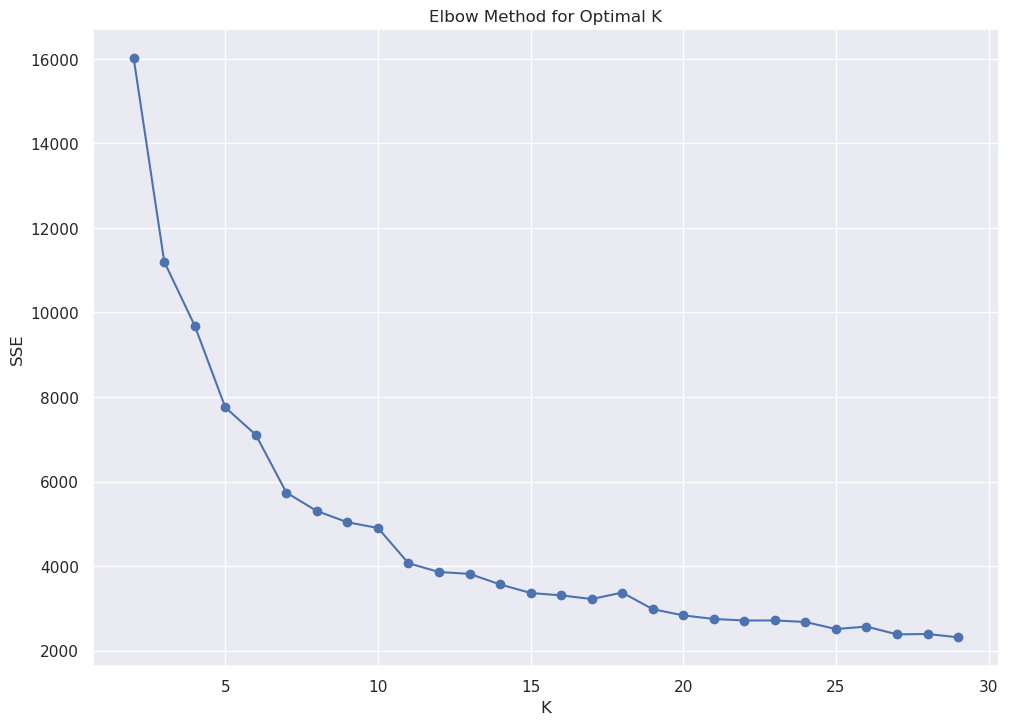

Elbow detected at K = 7


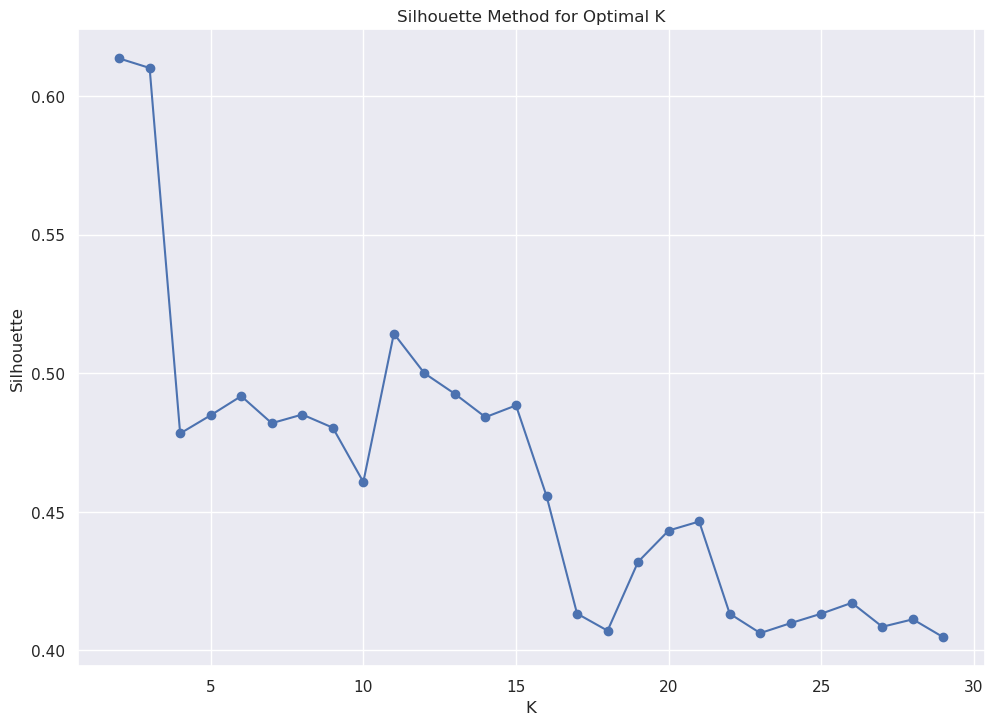

In [92]:
!pip install kneed
!pip install yellowbrick
from kneed import KneeLocator
import matplotlib.pyplot as plt


sse_values = []
silhouette_values = []
for k in range(2,30):

    print('************************************************\n')
    kmeans = KMeans(featuresCol="features_scaled", k=k)
    model = kmeans.fit(clusteringData)
    evaluator = ClusteringEvaluator(featuresCol="features_scaled")
    predictions = model.transform(clusteringData)
    silhouette = evaluator.evaluate(predictions)
    sse = model.summary.trainingCost
    
    print(f"Results for K = {k}")
    print(f"Silhouette with squared euclidean distance: {silhouette:.4f}")
    print(f"SSE (Sum of Squared Errors): {sse}")
    sse_values.append(sse)
    silhouette_values.append(silhouette)

# Plot SSE per valutare l'elbow
plt.figure()
plt.plot(range(2, 30), sse_values, marker='o')
plt.xlabel("K")
plt.ylabel("SSE")
plt.title("Elbow Method for Optimal K")
plt.show()

# Trova l'elbow con KneeLocator
kl = KneeLocator(range(2, 30), sse_values, curve="convex", direction="decreasing")
print(f"Elbow detected at K = {kl.elbow}")

plt.figure()
plt.plot(range(2, 30), silhouette_values, marker='o')
plt.xlabel("K")
plt.ylabel("Silhouette")
plt.title("Silhouette Method for Optimal K")
plt.show()

Facendo un tradeoff tra silhouette e SSE si puo dire che il k ideale per i nostri dati è compreso tra [6-8]

K-Means(K=6) with respect to Severity

Silhouette  = 0.5083980694366276

SSE  = 2442.4888119802854


Contingency Table:
severity      1      2    3    4
prediction                      
0           510  11947  298  444
1            88  17625  326  342
2             7  14058  345  141
3            52  10752  417  254
4           606  10549  388  503
5           195  12579  354  487


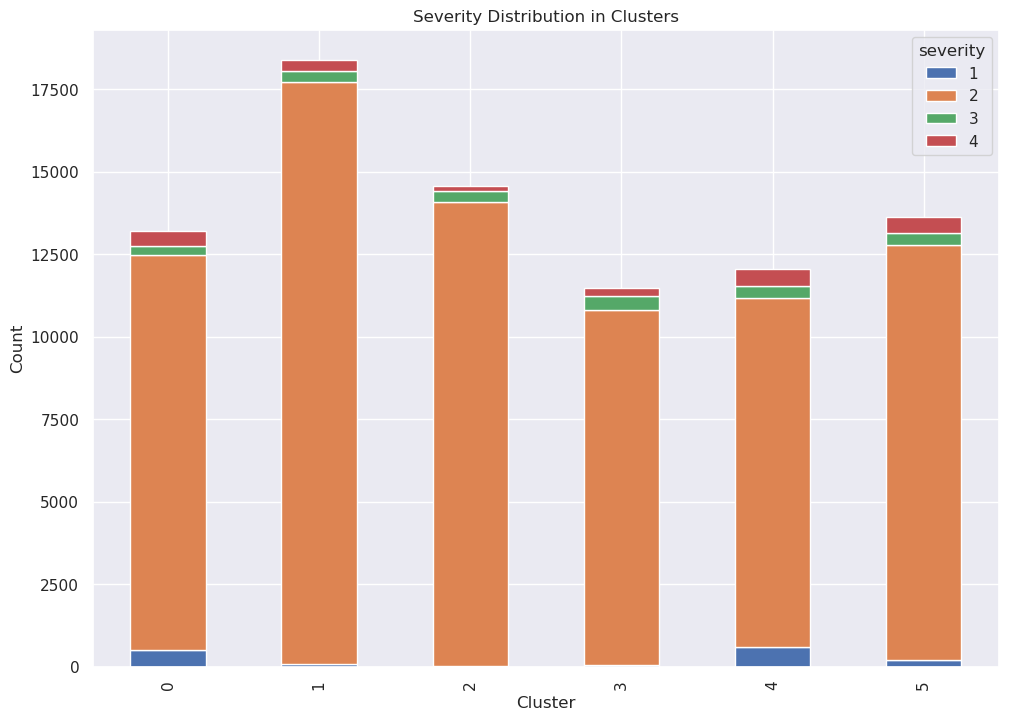

In [93]:
df_cluster_severity=df
to_drop=['Start_Time','City','County','Wind_Direction','Weather_Condition','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal','Astronomical_Twilight']
df_cluster_severity=df_cluster_severity.drop(*to_drop)

col = ['Distance_mi','Temperature_F','Humidity_perc','Visibility_mi','Wind_Speed_mph','Precipitation_in']

assembler = VectorAssembler(
    inputCols=col,
    outputCol="features")

output_dataset = assembler.transform(df_cluster_severity)
scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")
output_dataset = scaler.fit(output_dataset).transform(output_dataset)
clusteringData_severity = output_dataset.select("features_scaled", "Severity")

kmeans = KMeans(featuresCol="features_scaled").setK(6)
model = kmeans.fit(clusteringData_severity)
predictions = model.transform(clusteringData_severity)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'severity').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='severity', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Severity Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

K-Means(K=6) with respect to State

Silhouette  = 0.5083980694366276

SSE  = 2442.4888119802854
Contingency Table:
state         MI    MN    MT   ND    WI
prediction                             
0           5350  4762  1551  153  1383
1           4762  8498  3642  339  1140
2           2722  7789  3067  305   668
3           4154  4039  2216   73   993
4           5314  4369   576  126  1661
5           5257  4854  1916  107  1481


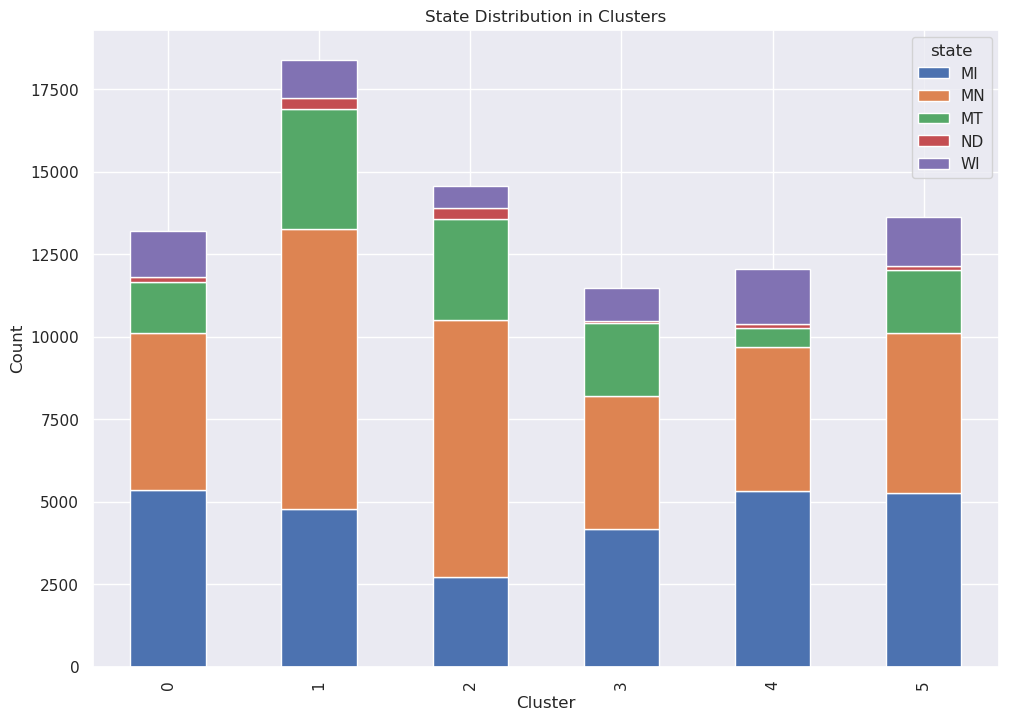

In [94]:
df_cluster_state=df
to_drop=['Start_Time','City','County','Wind_Direction','Weather_Condition','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal','Astronomical_Twilight']
df_cluster_state=df_cluster_state.drop(*to_drop)

col = ['Distance_mi','Temperature_F','Humidity_perc','Visibility_mi','Wind_Speed_mph','Precipitation_in']

assembler = VectorAssembler(
    inputCols=col,
    outputCol="features")

output_dataset = assembler.transform(df_cluster_state)
scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")
output_dataset = scaler.fit(output_dataset).transform(output_dataset)
clusteringData_state = output_dataset.select("features_scaled", "State")

kmeans = KMeans(featuresCol="features_scaled").setK(6)
model = kmeans.fit(clusteringData_state)
predictions = model.transform(clusteringData_state)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'state').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='state', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='State Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

K-Means(K=6) with respect to Astronomical Twilight

Silhouette  = 0.5083980694366276

SSE  = 2442.4888119802854


Contingency Table:
Astronomical_Twilight    Day  Night
prediction                         
0                       9897   3302
1                      13860   4521
2                      10017   4534
3                       9639   1836
4                      10725   1321
5                      12988    627


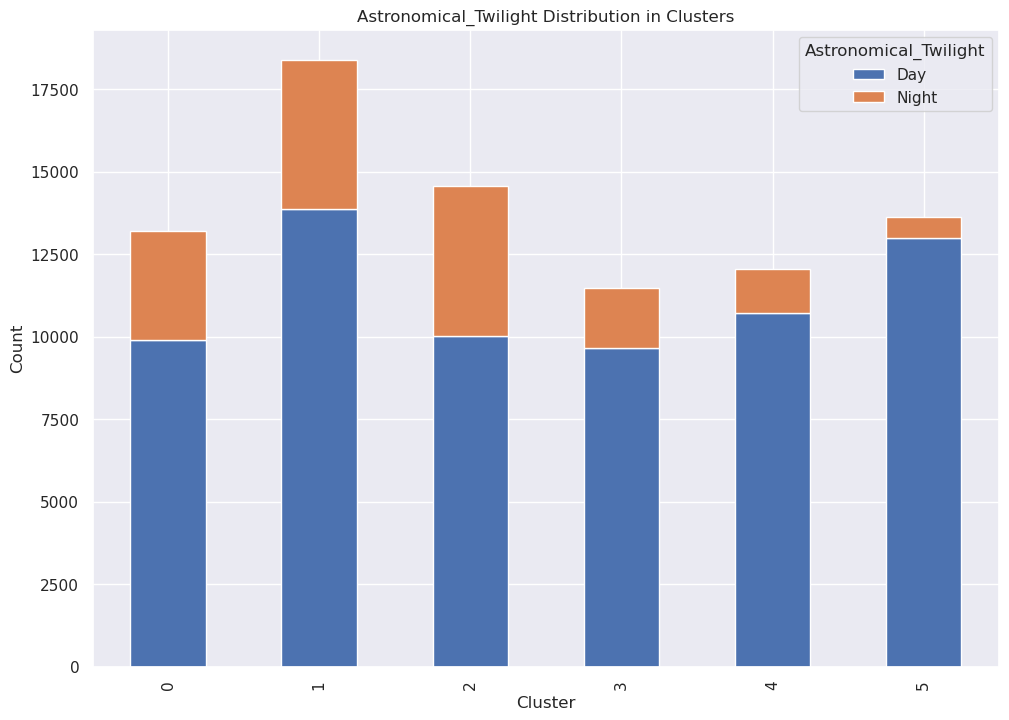

In [95]:
df_cluster_day=df
to_drop=['Start_Time','City','County','Wind_Direction','Weather_Condition','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal']
df_cluster_day=df_cluster_day.drop(*to_drop)

col = ['Distance_mi','Temperature_F','Humidity_perc','Visibility_mi','Wind_Speed_mph','Precipitation_in']

assembler = VectorAssembler(
    inputCols=col,
    outputCol="features")

output_dataset = assembler.transform(df_cluster_day)
scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")
output_dataset = scaler.fit(output_dataset).transform(output_dataset)
clusteringData_day = output_dataset.select("features_scaled", "Astronomical_Twilight")

kmeans = KMeans(featuresCol="features_scaled").setK(6)
model = kmeans.fit(clusteringData_day)
predictions = model.transform(clusteringData_day)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'Astronomical_Twilight').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='Astronomical_Twilight', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Astronomical_Twilight Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

K-Means(K=6) with respect to Weather_Condition

Silhouette  = 0.5083980694366276

SSE  = 2442.4888119802854
Contingency Table:
Weather_Condition  Cloudy  Foggy  Normal  Rain   Snow
prediction                                           
0                    6886    162    3423  1833    895
1                    1423   1664     287  2129  12878
2                    6885    214    6055    72   1325
3                    6401     14    4807   141    112
4                    5753     30    5828   432      3
5                    4871     43    8587   106      8


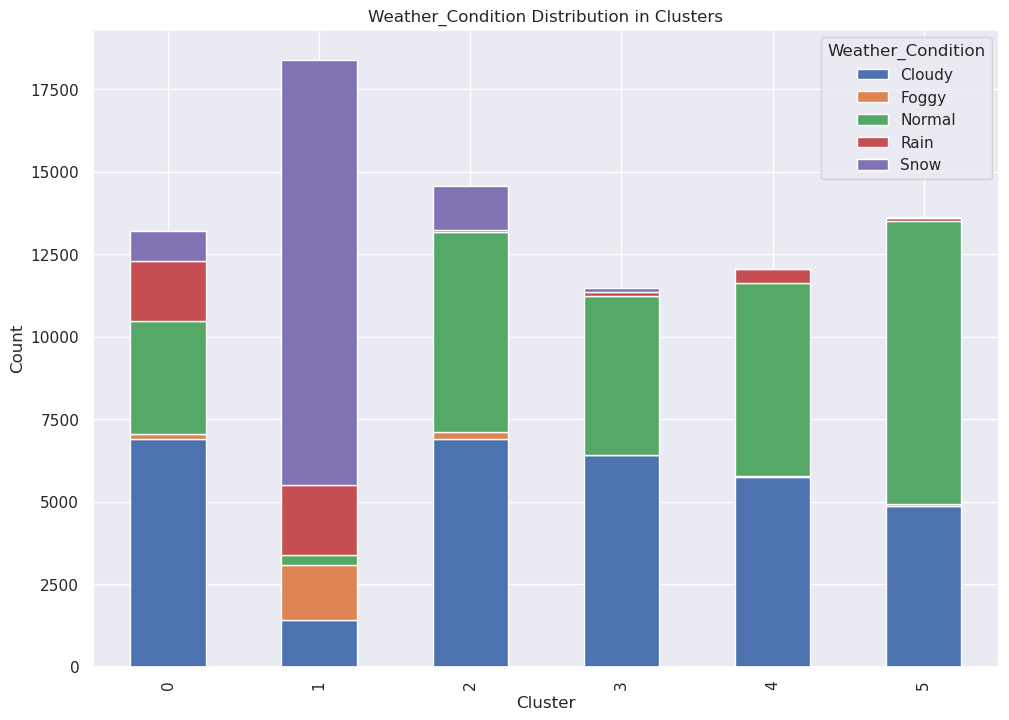

In [96]:
df_cluster_condition=df
to_drop=['Start_Time','City','County','Wind_Direction','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal']
df_cluster_condition=df_cluster_condition.drop(*to_drop)

col = ['Distance_mi','Temperature_F','Humidity_perc','Visibility_mi','Wind_Speed_mph','Precipitation_in']

assembler = VectorAssembler(
    inputCols=col,
    outputCol="features")

output_dataset = assembler.transform(df_cluster_condition)
scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")
output_dataset = scaler.fit(output_dataset).transform(output_dataset)
clusteringData_condition = output_dataset.select("features_scaled", "Weather_Condition")

kmeans = KMeans(featuresCol="features_scaled").setK(6)
model = kmeans.fit(clusteringData_condition)
predictions = model.transform(clusteringData_condition)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'Weather_Condition').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='Weather_Condition', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Weather_Condition Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

K-Means(K=6) with respect to day_of_the_week

Silhouette  = 0.5083980694366276

SSE  = 2442.4888119802854


Contingency Table:
day_of_the_week  Friday  Monday  Saturday  Sunday  Thursday  Tuesday  \
prediction                                                             
0                  2095    1875      1400    1264      2177     1844   
1                  4433    2729      1690    1167      2654     2470   
2                  2827    2302      1924    1608      2201     1968   
3                  2125    1707      1301    1137      1641     2052   
4                  2065    1501      1357    1162      1936     1848   
5                  2452    1840      1308    1136      2662     2195   

day_of_the_week  Wednesday  
prediction                  
0                     2544  
1                     3238  
2                     1721  
3                     1512  
4                     2177  
5                     2022  


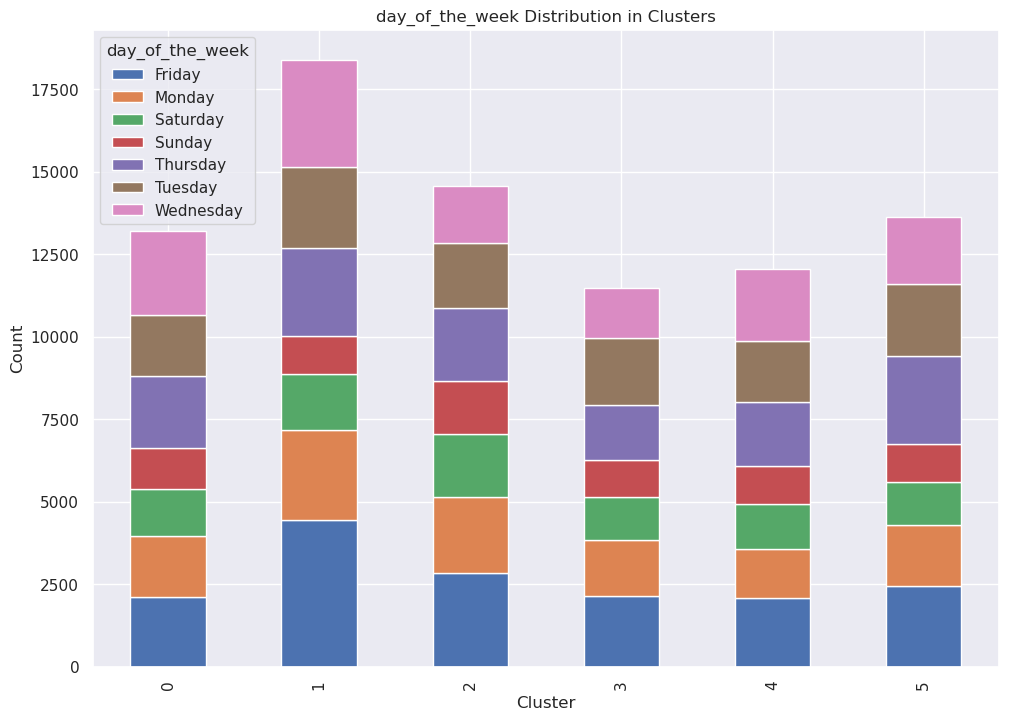

In [97]:
df_cluster_dayweek=df
to_drop=['Start_Time','City','County','Wind_Direction','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal']
df_cluster_dayweek=df_cluster_dayweek.drop(*to_drop)

col = ['Distance_mi','Temperature_F','Humidity_perc','Visibility_mi','Wind_Speed_mph','Precipitation_in']

assembler = VectorAssembler(
    inputCols=col,
    outputCol="features")

output_dataset = assembler.transform(df_cluster_dayweek)
scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")
output_dataset = scaler.fit(output_dataset).transform(output_dataset)
clusteringData_dayweek = output_dataset.select("features_scaled", "day_of_the_week")

kmeans = KMeans(featuresCol="features_scaled").setK(6)
model = kmeans.fit(clusteringData_dayweek)
predictions = model.transform(clusteringData_dayweek)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'day_of_the_week').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='day_of_the_week', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='day_of_the_week Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

K-Means(K=6) with respect to season

Silhouette  = 0.5083980694366276

SSE  = 2442.4888119802854
Contingency Table:
Season      Autumn  Spring  Summer   Winter
prediction                                 
0           3660.0  4046.0  2751.0   2742.0
1           2784.0  3439.0   715.0  11443.0
2           1559.0  1215.0     NaN  11777.0
3           2404.0  4653.0    45.0   4373.0
4           2954.0  1946.0  7139.0      7.0
5           3235.0  3078.0  7221.0     81.0


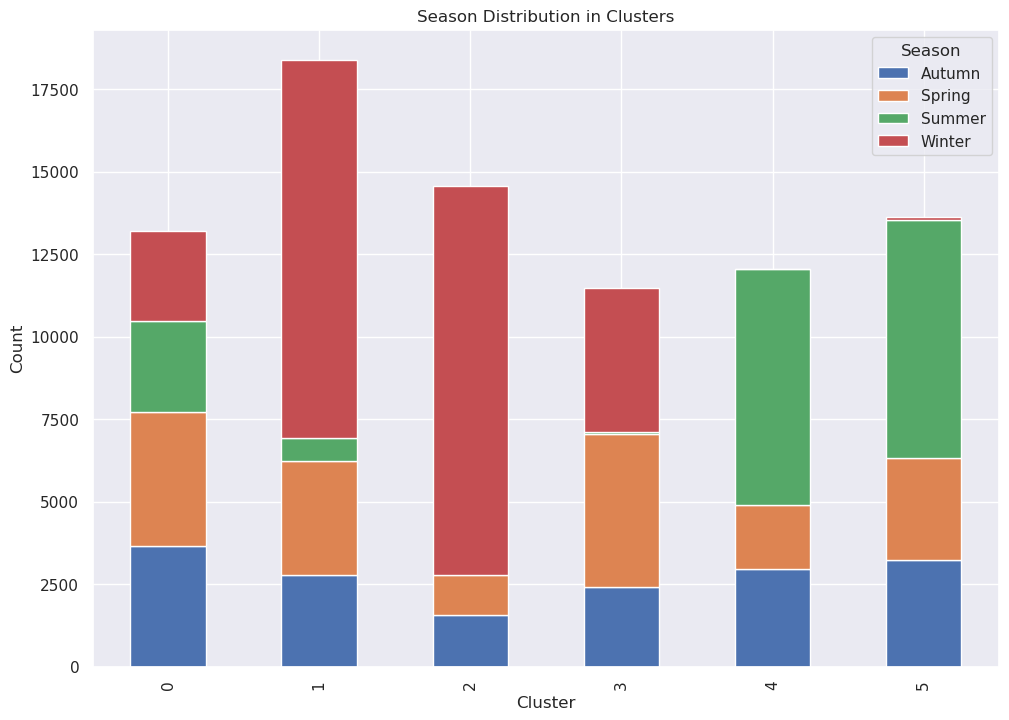

In [98]:
df_cluster_season=df
to_drop=['Start_Time','City','County','Wind_Direction','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal']
df_cluster_season=df_cluster_season.drop(*to_drop)

col = ['Distance_mi','Temperature_F','Humidity_perc','Visibility_mi','Wind_Speed_mph','Precipitation_in']

assembler = VectorAssembler(
    inputCols=col,
    outputCol="features")

output_dataset = assembler.transform(df_cluster_season)
scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")
output_dataset = scaler.fit(output_dataset).transform(output_dataset)
clusteringData_season = output_dataset.select("features_scaled", "season")

kmeans = KMeans(featuresCol="features_scaled").setK(6)
model = kmeans.fit(clusteringData_season)
predictions = model.transform(clusteringData_season)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'Season').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='Season', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Season Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


K-Means(K=6) with respect to Working_Weekend

Silhouette  = 0.5083980694366276

SSE  = 2442.4888119802854
Contingency Table:
Working_Weekend  Weekend  WorkingDay
prediction                          
0                   2664       10535
1                   2857       15524
2                   3532       11019
3                   2438        9037
4                   2519        9527
5                   2444       11171


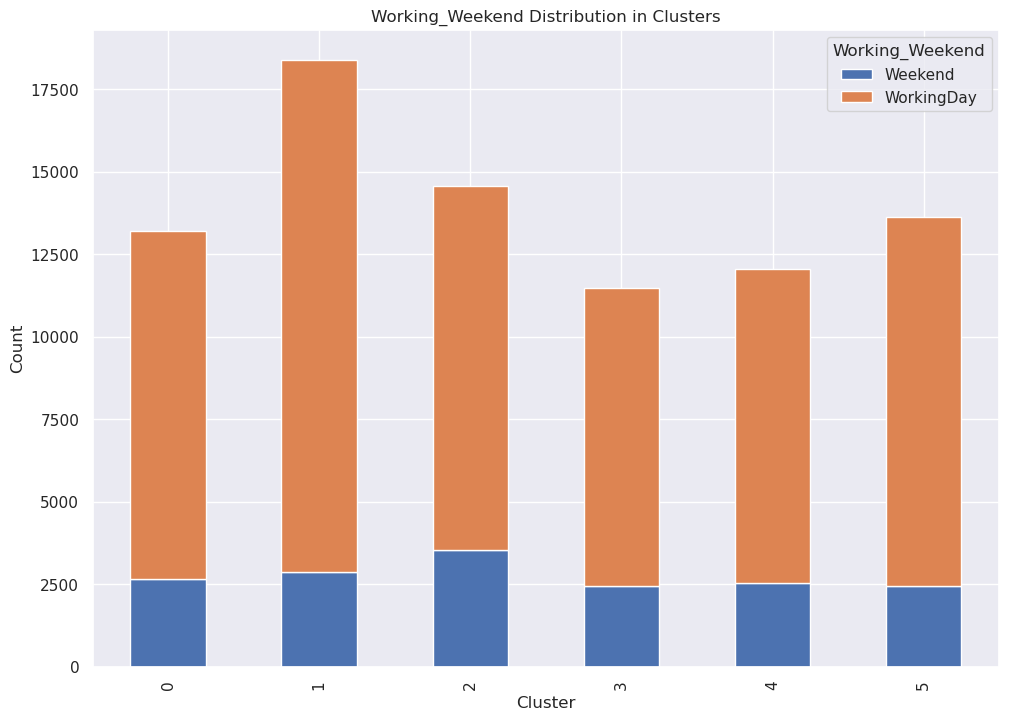

In [99]:
df_cluster_working=df
to_drop=['Start_Time','City','County','Wind_Direction','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal']
df_cluster_working=df_cluster_working.drop(*to_drop)

col = ['Distance_mi','Temperature_F','Humidity_perc','Visibility_mi','Wind_Speed_mph','Precipitation_in']

assembler = VectorAssembler(
    inputCols=col,
    outputCol="features")

output_dataset = assembler.transform(df_cluster_working)
scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")
output_dataset = scaler.fit(output_dataset).transform(output_dataset)
clusteringData_working = output_dataset.select("features_scaled", "Working_Weekend")

kmeans = KMeans(featuresCol="features_scaled").setK(6)
model = kmeans.fit(clusteringData_working)
predictions = model.transform(clusteringData_working)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'Working_Weekend').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='Working_Weekend', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Working_Weekend Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

K-Means(K=7) with respect to State

Silhouette  = 0.5228624069653681

SSE  = 1955.0721739912003
Contingency Table:
state         MI    MN    MT   ND    WI
prediction                             
0           3990  4541  2659  205  1007
1           3662  6478  3088  272   807
2           5710  4487   456  120  1768
3           4134  3623  2131   64   944
4           2293  3456  1088  121   655
5           6216  5724  1964  144  1781
6           1554  6002  1582  177   364


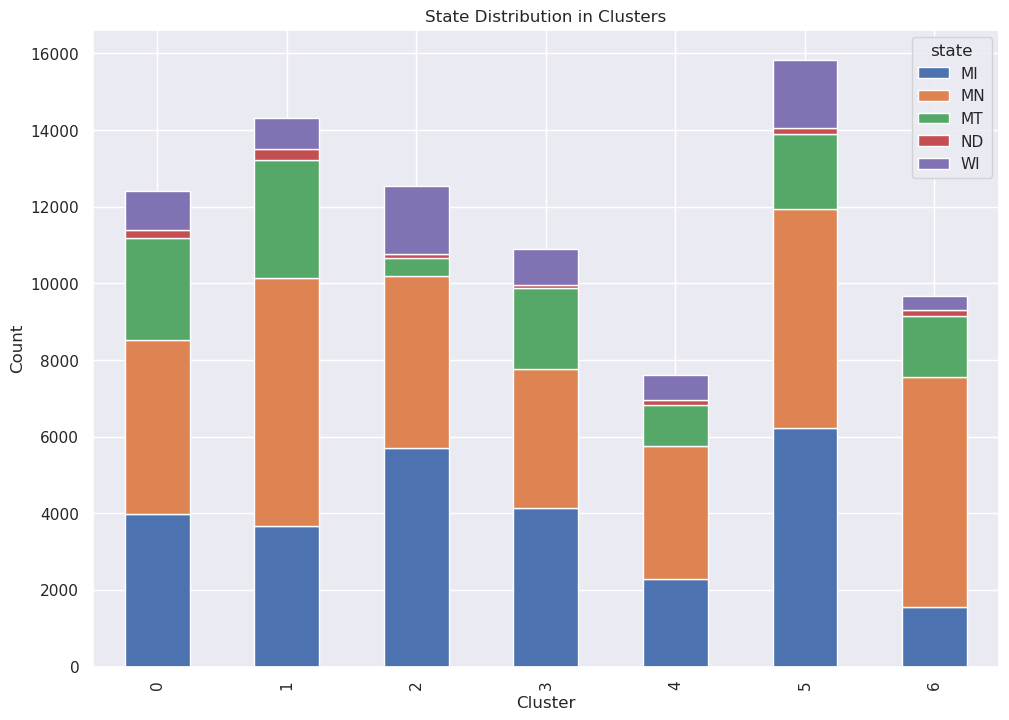

In [100]:
clusteringData_state = output_dataset.select("features_scaled", "State")

kmeans = KMeans(featuresCol="features_scaled").setK(7)
model = kmeans.fit(clusteringData_state)
predictions = model.transform(clusteringData_state)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'state').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='state', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='State Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

K-Means(K=7) with respect to Astronomical Twilight

Silhouette  = 0.5228624069653681

SSE  = 1955.0721739912005
Contingency Table:
Astronomical_Twilight    Day  Night
prediction                         
0                       8630   3772
1                      11066   3241
2                      10732   1809
3                       9243   1653
4                       5339   2274
5                      15059    770
6                       7057   2622


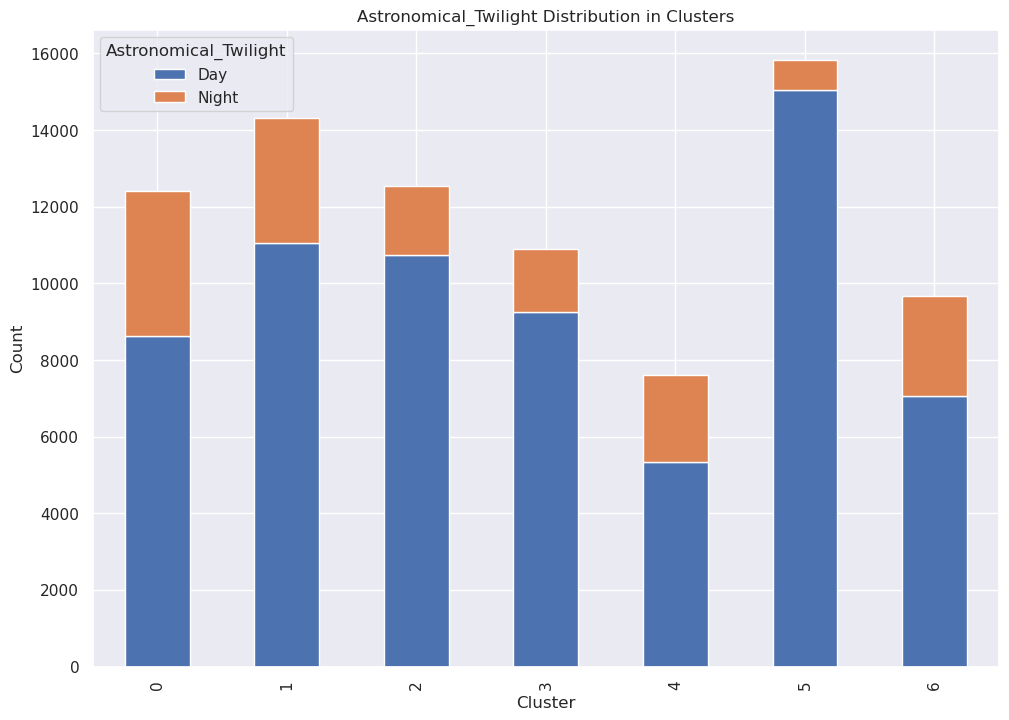

In [101]:
clusteringData_day = output_dataset.select("features_scaled", "Astronomical_Twilight")

kmeans = KMeans(featuresCol="features_scaled").setK(7)
model = kmeans.fit(clusteringData_day)
predictions = model.transform(clusteringData_day)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'Astronomical_Twilight').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='Astronomical_Twilight', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Astronomical_Twilight Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

K-Means(K=7) with respect to Weather_Condition

Silhouette  = 0.5228624069653681

SSE  = 1955.0721739912003
Contingency Table:
Weather_Condition  Cloudy   Foggy  Normal    Rain     Snow
prediction                                                
0                  7825.0    17.0  3127.0   669.0    764.0
1                   490.0  1362.0    38.0  1306.0  11111.0
2                  6193.0    17.0  5376.0   955.0      NaN
3                  5928.0     6.0  4769.0   116.0     77.0
4                  2107.0   678.0   616.0  1500.0   2712.0
5                  5830.0    42.0  9817.0   132.0      8.0
6                  3846.0     5.0  5244.0    35.0    549.0


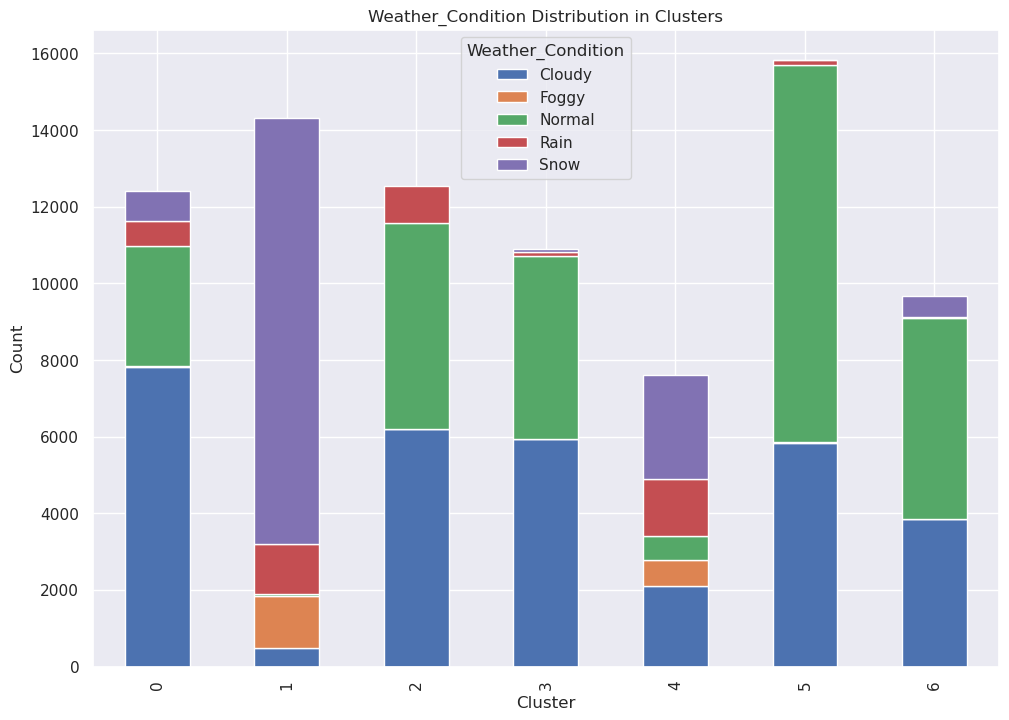

In [102]:
clusteringData_condition = output_dataset.select("features_scaled", "Weather_Condition")

kmeans = KMeans(featuresCol="features_scaled").setK(7)
model = kmeans.fit(clusteringData_condition)
predictions = model.transform(clusteringData_condition)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'Weather_Condition').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='Weather_Condition', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Weather_Condition Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

K-Means(K=7) with respect to day_of_the_week

Silhouette  = 0.5228624069653681

SSE  = 1955.0721739912003
Contingency Table:
day_of_the_week  Friday  Monday  Saturday  Sunday  Thursday  Tuesday  \
prediction                                                             
0                  2136    2018      1179    1150      2019     1905   
1                  3403    2090      1284     928      2050     1980   
2                  1951    1636      1507    1366      1955     1797   
3                  1906    1636      1252    1130      1631     1925   
4                  1645    1182       833     509      1149      966   
5                  2918    2080      1516    1330      3006     2564   
6                  2038    1312      1409    1061      1461     1240   

day_of_the_week  Wednesday  
prediction                  
0                     1995  
1                     2572  
2                     2329  
3                     1416  
4                     1329  
5                     2415  
6                     1158  


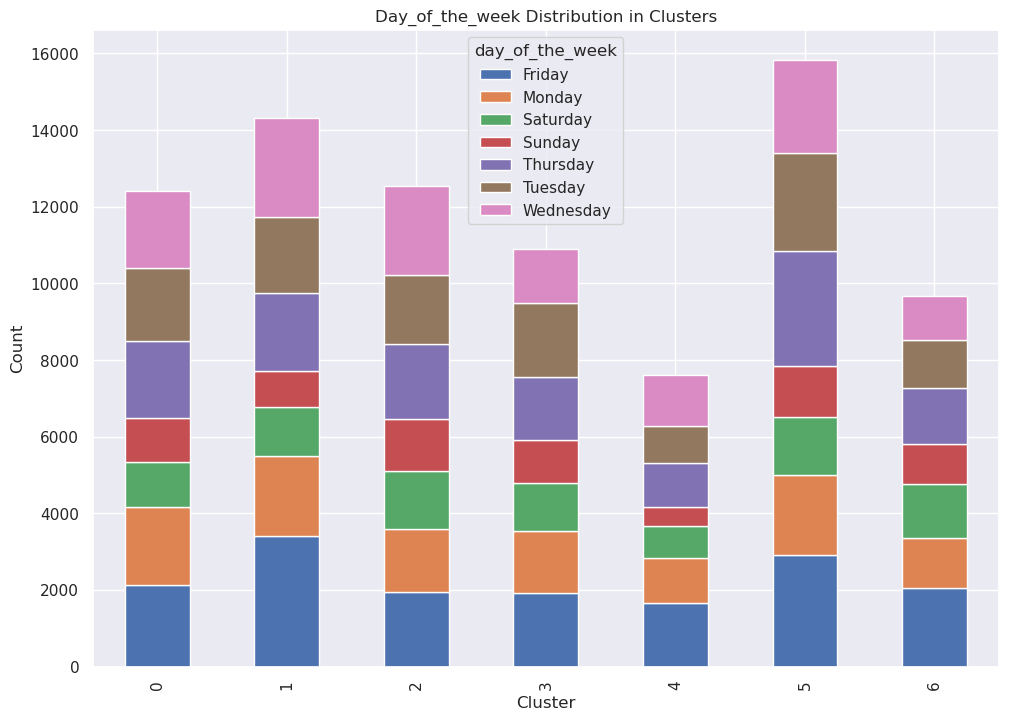

In [103]:
clusteringData_condition = output_dataset.select("features_scaled", "day_of_the_week")

kmeans = KMeans(featuresCol="features_scaled").setK(7)
model = kmeans.fit(clusteringData_condition)
predictions = model.transform(clusteringData_condition)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'day_of_the_week').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='day_of_the_week', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Day_of_the_week Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

K-Means(K=7) with respect to season

Silhouette  = 0.5228624069653681

SSE  = 1955.0721739912005


Contingency Table:
season      Autumn  Spring  Summer  Winter
prediction                                
0           3300.0  3724.0   339.0  5039.0
1           2094.0  2580.0   434.0  9199.0
2           3091.0  1863.0  7561.0    26.0
3           2468.0  4793.0   161.0  3474.0
4           1378.0  1721.0   531.0  3983.0
5           3745.0  3187.0  8845.0    52.0
6            520.0   509.0     NaN  8650.0


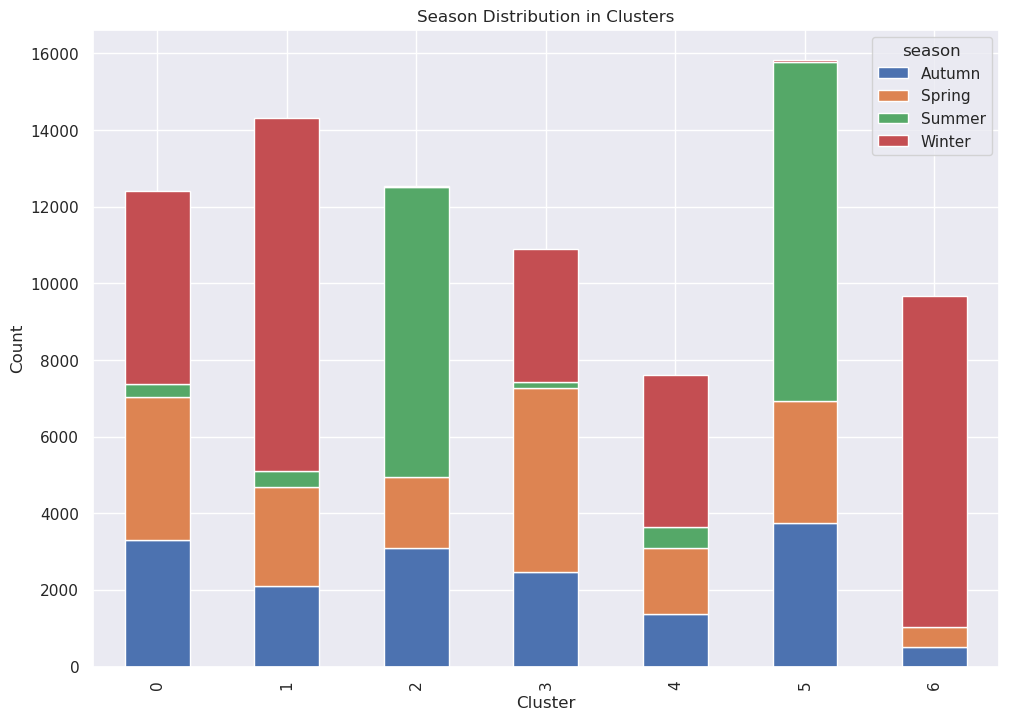

In [104]:
clusteringData_condition = output_dataset.select("features_scaled", "season")

kmeans = KMeans(featuresCol="features_scaled").setK(7)
model = kmeans.fit(clusteringData_condition)
predictions = model.transform(clusteringData_condition)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'season').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='season', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Season Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

# Bisecting K-Means with k in range(2,30)

+-----------------------------------------------------------------------------------------------------------+--------+
|features_scaled                                                                                            |Severity|
+-----------------------------------------------------------------------------------------------------------+--------+
|[0.0,0.5102040816326531,0.6363636363636365,1.0,0.1,0.0]                                                    |3       |
|[0.005443745162050281,0.5102040816326531,0.6363636363636365,1.0,0.1,0.0]                                   |2       |
|[0.007799616329552722,0.5102040816326531,0.6363636363636365,1.0,0.07692307692307693,0.0]                   |2       |
|[0.005443745162050281,0.5102040816326531,0.6363636363636365,1.0,0.07692307692307693,0.0]                   |2       |
|[0.0,0.4149659863945578,0.7070707070707072,1.0,0.09230769230769231,0.0]                                    |3       |
|[0.0,0.4149659863945578,0.7373737373737375,1.0,

Results for K = 2
Silhouette with squared euclidean distance: 0.7914
SSE (Sum of Squared Errors): 5903.216130072764
************************************************



Results for K = 3
Silhouette with squared euclidean distance: 0.6213
SSE (Sum of Squared Errors): 3709.249952395414
************************************************



Results for K = 4
Silhouette with squared euclidean distance: 0.5589
SSE (Sum of Squared Errors): 3247.0913417368574
************************************************



Results for K = 5
Silhouette with squared euclidean distance: 0.5204
SSE (Sum of Squared Errors): 2615.761960484131
************************************************



Results for K = 6
Silhouette with squared euclidean distance: 0.4502
SSE (Sum of Squared Errors): 2304.3104667308326
************************************************



Results for K = 7
Silhouette with squared euclidean distance: 0.4097
SSE (Sum of Squared Errors): 2185.488265969745
************************************************



Results for K = 8
Silhouette with squared euclidean distance: 0.4121
SSE (Sum of Squared Errors): 2069.7190227817473
************************************************



Results for K = 9
Silhouette with squared euclidean distance: 0.3725
SSE (Sum of Squared Errors): 1896.8749821107986
************************************************



Results for K = 10
Silhouette with squared euclidean distance: 0.3672
SSE (Sum of Squared Errors): 1761.9448802803172
************************************************



Results for K = 11
Silhouette with squared euclidean distance: 0.3561
SSE (Sum of Squared Errors): 1636.06921554996
************************************************



Results for K = 12
Silhouette with squared euclidean distance: 0.3662
SSE (Sum of Squared Errors): 1548.0559474916872
************************************************



Results for K = 13
Silhouette with squared euclidean distance: 0.3585
SSE (Sum of Squared Errors): 1511.2387563641828
************************************************



Results for K = 14
Silhouette with squared euclidean distance: 0.3459
SSE (Sum of Squared Errors): 1489.3849879900943
************************************************



Results for K = 15
Silhouette with squared euclidean distance: 0.3440
SSE (Sum of Squared Errors): 1452.4363870164073
************************************************



Results for K = 16
Silhouette with squared euclidean distance: 0.3337
SSE (Sum of Squared Errors): 1431.8747612052343
************************************************



Results for K = 17
Silhouette with squared euclidean distance: 0.3274
SSE (Sum of Squared Errors): 1357.2108196319236
************************************************



Results for K = 18
Silhouette with squared euclidean distance: 0.3201
SSE (Sum of Squared Errors): 1308.4583719416391
************************************************



Results for K = 19
Silhouette with squared euclidean distance: 0.3139
SSE (Sum of Squared Errors): 1253.8017866878004
************************************************



Results for K = 20
Silhouette with squared euclidean distance: 0.2865
SSE (Sum of Squared Errors): 1214.5134838633062
************************************************



Results for K = 21
Silhouette with squared euclidean distance: 0.2917
SSE (Sum of Squared Errors): 1169.4765652992942
************************************************



Results for K = 22
Silhouette with squared euclidean distance: 0.3177
SSE (Sum of Squared Errors): 1059.8950986526866
************************************************



Results for K = 23
Silhouette with squared euclidean distance: 0.3035
SSE (Sum of Squared Errors): 1043.954791811682
************************************************



Results for K = 24
Silhouette with squared euclidean distance: 0.2920
SSE (Sum of Squared Errors): 1027.0374912631867
************************************************



Results for K = 25
Silhouette with squared euclidean distance: 0.2926
SSE (Sum of Squared Errors): 1014.4396537240726
************************************************



Results for K = 26
Silhouette with squared euclidean distance: 0.2921
SSE (Sum of Squared Errors): 1003.0393781622035
************************************************



Results for K = 27
Silhouette with squared euclidean distance: 0.2979
SSE (Sum of Squared Errors): 980.626007124823
************************************************



Results for K = 28
Silhouette with squared euclidean distance: 0.2959
SSE (Sum of Squared Errors): 965.9117412146475
************************************************



Results for K = 29
Silhouette with squared euclidean distance: 0.2963
SSE (Sum of Squared Errors): 958.5929593663734


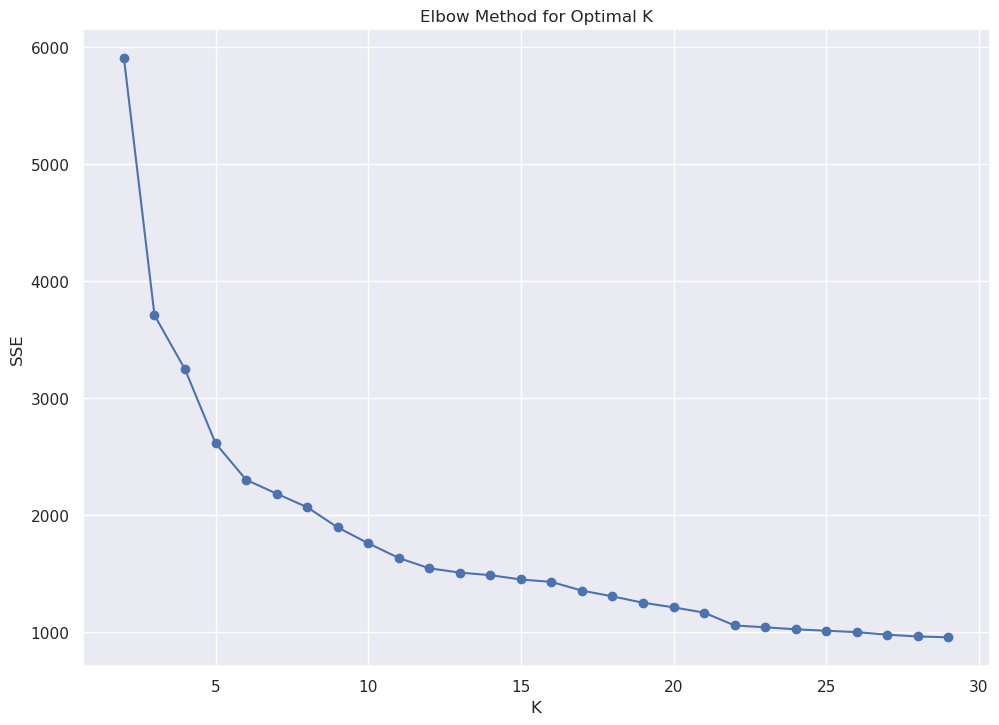

Elbow detected at K = 6


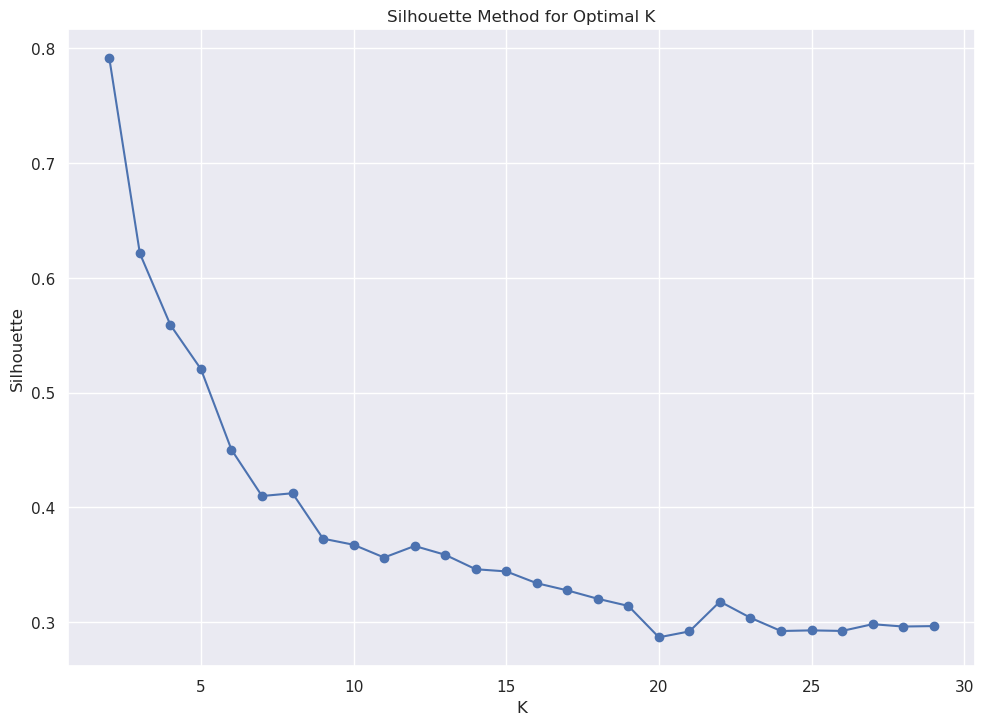

In [105]:
df_cluster_bisecting=df
to_drop=['Start_Time','City','County','Wind_Direction','Weather_Condition','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal','Astronomical_Twilight']
df_cluster_bisecting=df_cluster_bisecting.drop(*to_drop) # con asterisco passo gli elementi singoli al metodo drop


col = ['Distance_mi','Temperature_F','Humidity_perc','Visibility_mi','Wind_Speed_mph','Precipitation_in']

assembler = VectorAssembler(
    inputCols=col,
    outputCol="features")

output_dataset = assembler.transform(df_cluster_bisecting)

scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")

output_dataset = scaler.fit(output_dataset).transform(output_dataset)

clusteringData_bisecting = output_dataset.select("features_scaled", "Severity")

clusteringData_bisecting.show(truncate=False)



!pip install kneed
from kneed import KneeLocator
import matplotlib.pyplot as plt


sse_values = []
silhouette_values = []
for k in range(2,30):

    print('************************************************\n')

    bisect_kmeans=BisectingKMeans(featuresCol="features_scaled",k=k)
    model = bisect_kmeans.fit(clusteringData_bisecting)
    
    evaluator = ClusteringEvaluator(featuresCol="features_scaled")
    predictions = model.transform(clusteringData_bisecting)
    silhouette = evaluator.evaluate(predictions)
    sse = model.summary.trainingCost
    
    print(f"Results for K = {k}")
    print(f"Silhouette with squared euclidean distance: {silhouette:.4f}")
    print(f"SSE (Sum of Squared Errors): {sse}")
    sse_values.append(sse)
    silhouette_values.append(silhouette)

# Plot SSE per valutare l'elbow
plt.figure()
plt.plot(range(2, 30), sse_values, marker='o')
plt.xlabel("K")
plt.ylabel("SSE")
plt.title("Elbow Method for Optimal K")
plt.show()

# Trova l'elbow con KneeLocator
kl = KneeLocator(range(2, 30), sse_values, curve="convex", direction="decreasing")
print(f"Elbow detected at K = {kl.elbow}")

plt.figure()
plt.plot(range(2, 30), silhouette_values, marker='o')
plt.xlabel("K")
plt.ylabel("Silhouette")
plt.title("Silhouette Method for Optimal K")
plt.show()

Bisecting K-Means(K=6) with respect to Severity

Silhouette  = 0.4501514840482993

SSE  = 2304.3104667308326


Contingency Table:
severity      1      2    3    4
prediction                      
0            29  11643  211  228
1            63   6961  148  132
2            20  20426  649  273
3           715  14178  397  578
4           135  11714  322  412
5           496  12588  401  548


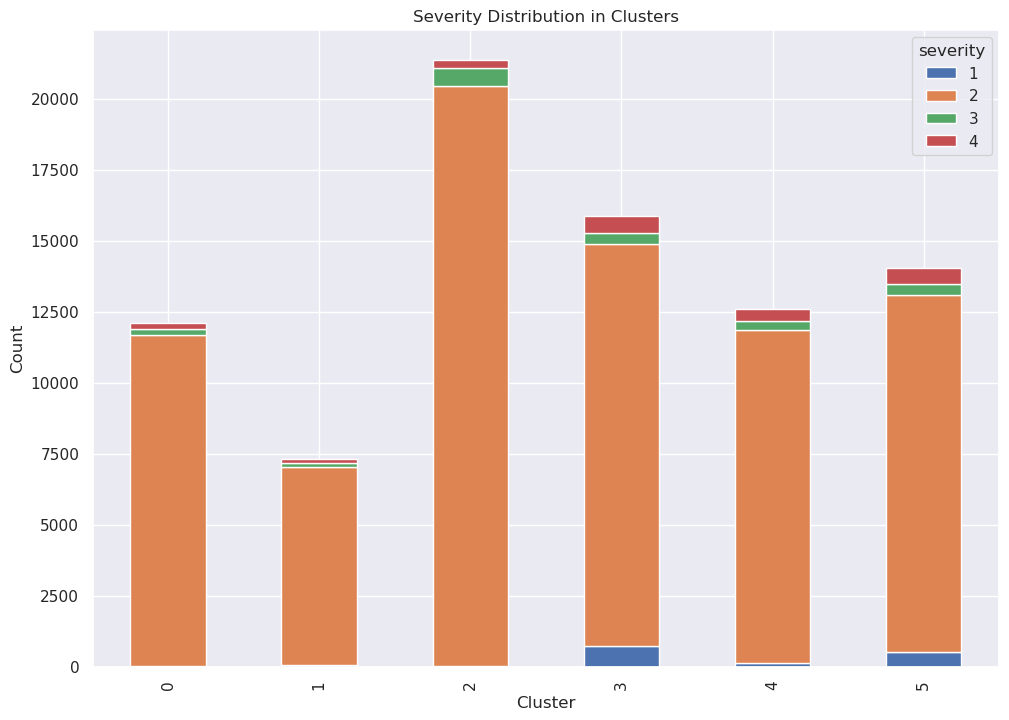

In [106]:
df_clusterbisecting_severity=df
to_drop=['Start_Time','City','County','Wind_Direction','Weather_Condition','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal','Astronomical_Twilight']
df_clusterbisecting_severity=df_clusterbisecting_severity.drop(*to_drop)

col = ['Distance_mi','Temperature_F','Humidity_perc','Visibility_mi','Wind_Speed_mph','Precipitation_in']

assembler = VectorAssembler(
    inputCols=col,
    outputCol="features")

output_dataset = assembler.transform(df_clusterbisecting_severity)
scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")
output_dataset = scaler.fit(output_dataset).transform(output_dataset)
bisectingclusteringData_severity = output_dataset.select("features_scaled", "Severity")

bisect_kmeans=BisectingKMeans(featuresCol="features_scaled",k=6)
model = bisect_kmeans.fit(bisectingclusteringData_severity)
predictions = model.transform(bisectingclusteringData_severity)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'severity').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='severity', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Severity Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

Bisecting K-Means(K=6) with respect to State

Silhouette  = 0.4501514840482993

SSE  = 2304.3104667308326


Contingency Table:
state         MI     MN    MT   ND    WI
prediction                              
0           3072   5398  2764  242   635
1           2042   3452  1134  138   538
2           5204  10286  4358  334  1186
3           6555   5648  1622  168  1875
4           4675   4500  1993   91  1324
5           6011   5027  1097  130  1768


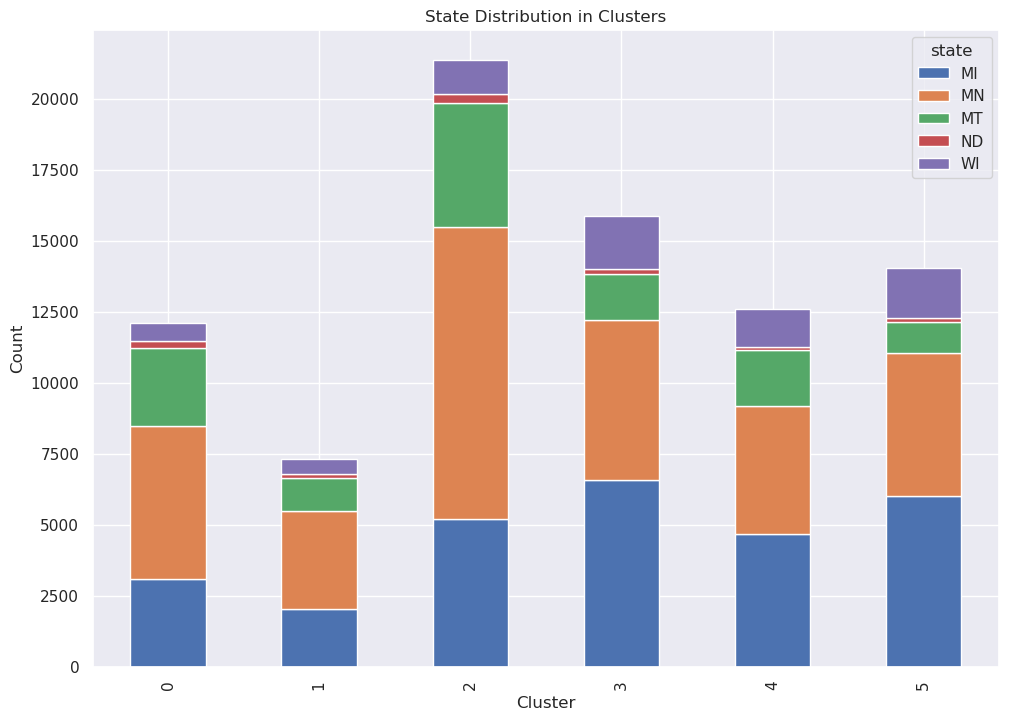

In [107]:
df_clusterbisecting_state=df
to_drop=['Start_Time','City','County','Wind_Direction','Weather_Condition','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal','Astronomical_Twilight']
df_clusterbisecting_state=df_clusterbisecting_state.drop(*to_drop)

col = ['Distance_mi','Temperature_F','Humidity_perc','Visibility_mi','Wind_Speed_mph','Precipitation_in']

assembler = VectorAssembler(
    inputCols=col,
    outputCol="features")

output_dataset = assembler.transform(df_clusterbisecting_state)
scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")
output_dataset = scaler.fit(output_dataset).transform(output_dataset)
bisectingclusteringData_state= output_dataset.select("features_scaled", "State")

bisect_kmeans=BisectingKMeans(featuresCol="features_scaled",k=6)
model = bisect_kmeans.fit(bisectingclusteringData_state)
predictions = model.transform(bisectingclusteringData_state)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'state').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='state', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='State Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

Bisecting K-Means(K=6) with respect to Astronomical_Twilight

Silhouette  = 0.4501514840482993

SSE  = 2304.3104667308326
Contingency Table:
Astronomical_Twilight    Day  Night
prediction                         
0                       9449   2662
1                       5144   2160
2                      15651   5717
3                      12256   3612
4                      12003    580
5                      12623   1410


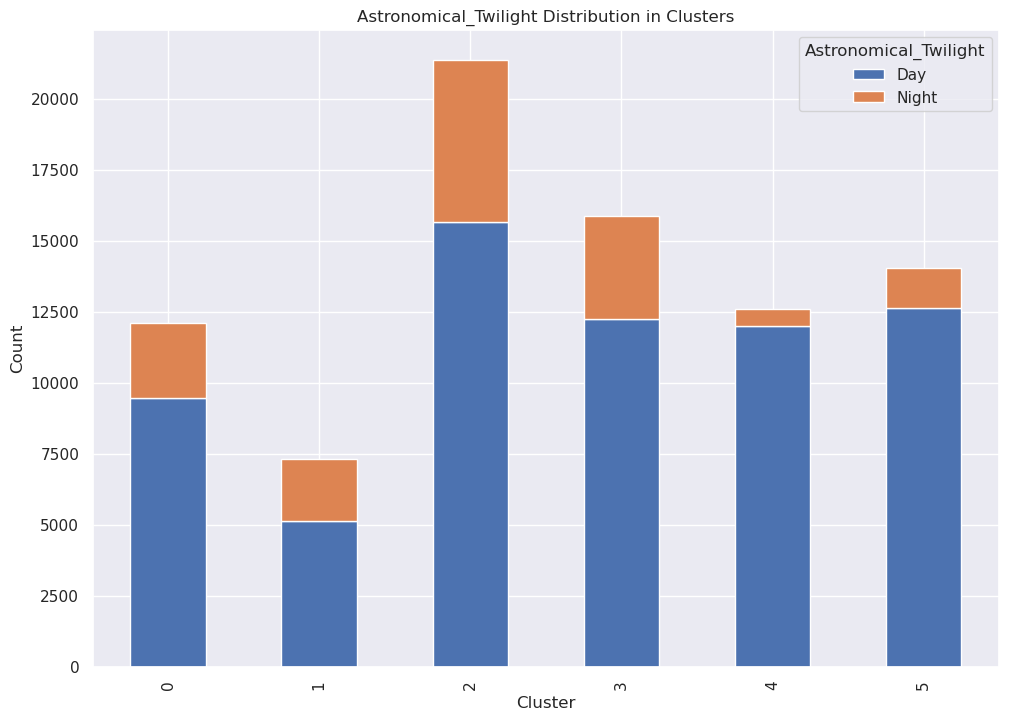

In [108]:
df_clusterbisecting_day=df
to_drop=['Start_Time','City','County','Wind_Direction','Weather_Condition','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal']
df_clusterbisecting_day=df_clusterbisecting_day.drop(*to_drop)

col = ['Distance_mi','Temperature_F','Humidity_perc','Visibility_mi','Wind_Speed_mph','Precipitation_in']

assembler = VectorAssembler(
    inputCols=col,
    outputCol="features")

output_dataset = assembler.transform(df_clusterbisecting_day)
scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")
output_dataset = scaler.fit(output_dataset).transform(output_dataset)
bisectingclusteringData_day= output_dataset.select("features_scaled", "Astronomical_Twilight")

bisect_kmeans=BisectingKMeans(featuresCol="features_scaled",k=6)
model = bisect_kmeans.fit(bisectingclusteringData_day)
predictions = model.transform(bisectingclusteringData_day)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'Astronomical_Twilight').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='Astronomical_Twilight', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Astronomical_Twilight Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

Bisecting K-Means(K=6) with respect to Weather_Condition

Silhouette  = 0.4501514840482993

SSE  = 2304.3104667308326


Contingency Table:
Weather_Condition  Cloudy  Foggy  Normal  Rain  Snow
prediction                                          
0                     208   1199       2   865  9837
1                    1429    736     325  1437  3377
2                   11034     28    8820   125  1361
3                    8352     93    4895  1893   635
4                    4456     41    7997    81     8
5                    6740     30    6948   312     3


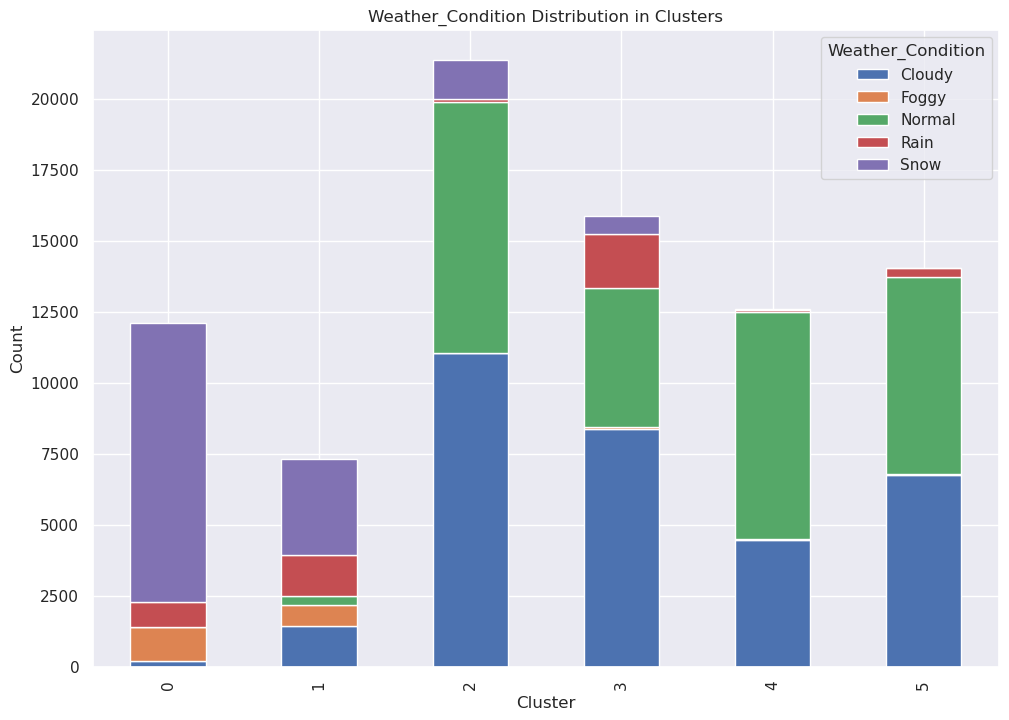

In [109]:
df_clusterbisecting_condition=df
to_drop=['Start_Time','City','County','Wind_Direction','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal']
df_clusterbisecting_condition=df_clusterbisecting_condition.drop(*to_drop)

col = ['Distance_mi','Temperature_F','Humidity_perc','Visibility_mi','Wind_Speed_mph','Precipitation_in']

assembler = VectorAssembler(
    inputCols=col,
    outputCol="features")

output_dataset = assembler.transform(df_clusterbisecting_condition)
scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")
output_dataset = scaler.fit(output_dataset).transform(output_dataset)
bisectingclusteringData_condition= output_dataset.select("features_scaled", "Weather_Condition")

bisect_kmeans=BisectingKMeans(featuresCol="features_scaled",k=6)
model = bisect_kmeans.fit(bisectingclusteringData_condition)
predictions = model.transform(bisectingclusteringData_condition)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'Weather_Condition').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='Weather_Condition', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Weather_Condition Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

Bisecting K-Means(K=6) with respect to day_of_the_week

Silhouette  = 0.4501514840482993

SSE  = 2304.3104667308326


Contingency Table:
day_of_the_week  Friday  Monday  Saturday  Sunday  Thursday  Tuesday  \
prediction                                                             
0                  2788    1806      1063     765      1784     1681   
1                  1836    1096       761     448      1025      924   
2                  4082    3326      2661    2280      3195     3121   
3                  2531    2279      1684    1558      2591     2246   
4                  2328    1708      1253    1081      2414     2015   
5                  2432    1739      1558    1342      2262     2390   

day_of_the_week  Wednesday  
prediction                  
0                     2224  
1                     1214  
2                     2703  
3                     2979  
4                     1784  
5                     2310  


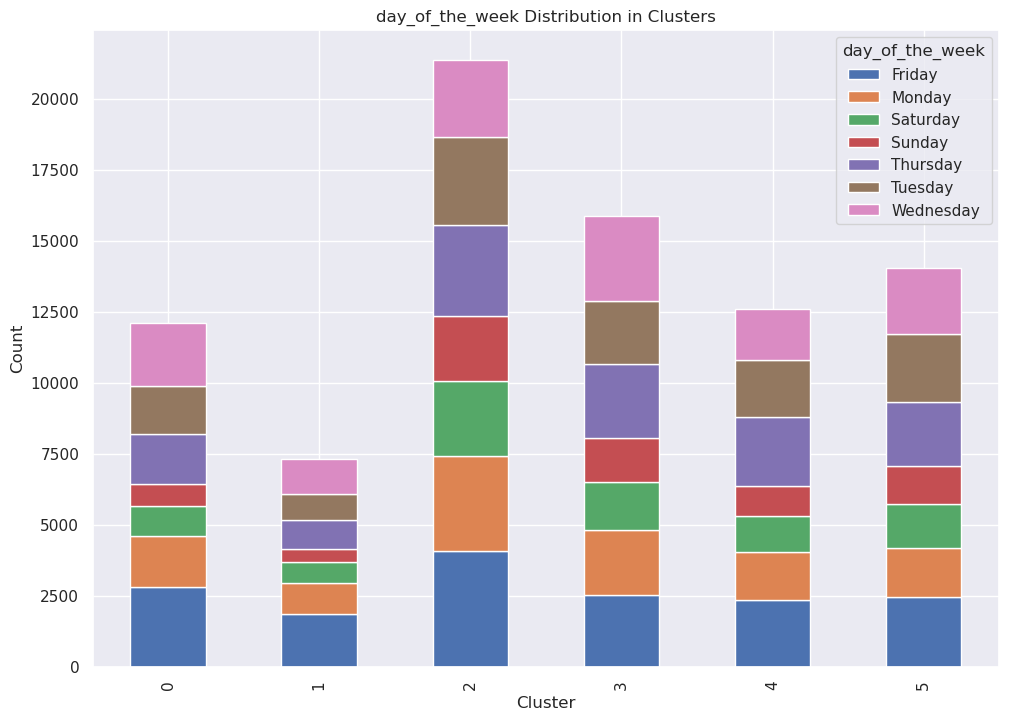

In [110]:
df_clusterbisecting_dayweek=df
to_drop=['Start_Time','City','County','Wind_Direction','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal']
df_clusterbisecting_dayweek=df_clusterbisecting_dayweek.drop(*to_drop)

col = ['Distance_mi','Temperature_F','Humidity_perc','Visibility_mi','Wind_Speed_mph','Precipitation_in']

assembler = VectorAssembler(
    inputCols=col,
    outputCol="features")

output_dataset = assembler.transform(df_clusterbisecting_dayweek)
scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")
output_dataset = scaler.fit(output_dataset).transform(output_dataset)
bisectingclusteringData_dayweek= output_dataset.select("features_scaled", "day_of_the_week")

bisect_kmeans=BisectingKMeans(featuresCol="features_scaled",k=6)
model = bisect_kmeans.fit(bisectingclusteringData_dayweek)
predictions = model.transform(bisectingclusteringData_dayweek)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'day_of_the_week').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='day_of_the_week', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='day_of_the_week Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

Bisecting K-Means(K=6) with respect to season

Silhouette  = 0.4501514840482993

SSE  = 2304.3104667308326


Contingency Table:
season      Autumn  Spring  Summer  Winter
prediction                                
0             1753    2094     301    7963
1             1198    1603     446    4057
2             2817    3279       3   15269
3             4608    4597    4362    2301
4             2868    3271    6177     267
5             3352    3533    6582     566


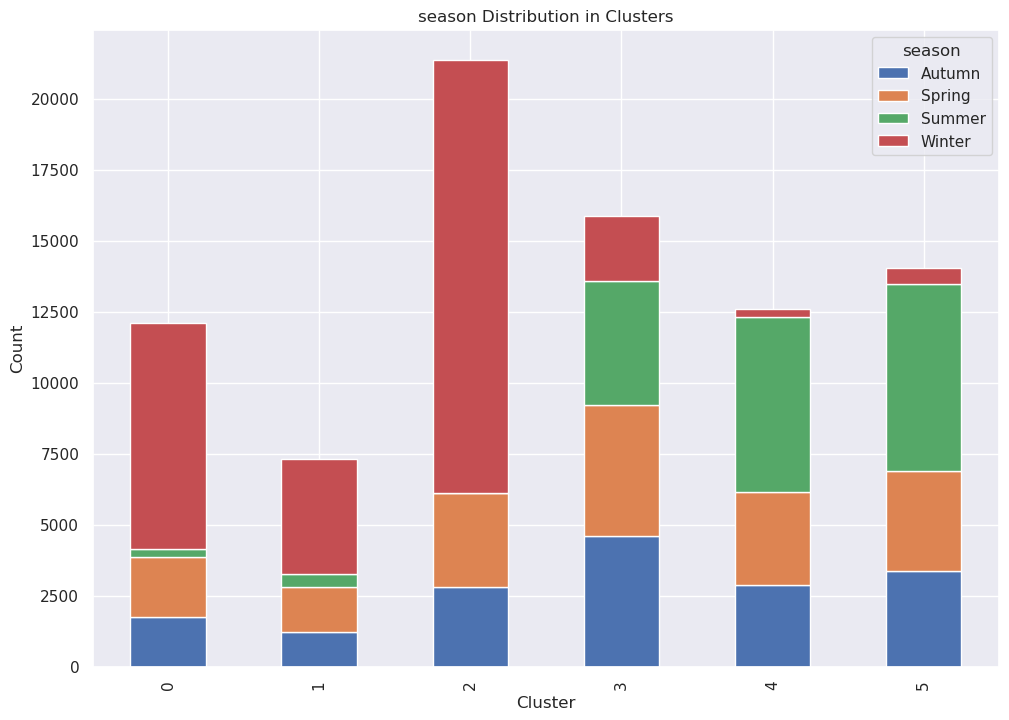

In [111]:
df_clusterbisecting_season=df
to_drop=['Start_Time','City','County','Wind_Direction','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal']
df_clusterbisecting_season=df_clusterbisecting_season.drop(*to_drop)

col = ['Distance_mi','Temperature_F','Humidity_perc','Visibility_mi','Wind_Speed_mph','Precipitation_in']

assembler = VectorAssembler(
    inputCols=col,
    outputCol="features")

output_dataset = assembler.transform(df_clusterbisecting_season)
scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")
output_dataset = scaler.fit(output_dataset).transform(output_dataset)
bisectingclusteringData_season= output_dataset.select("features_scaled", "season")

bisect_kmeans=BisectingKMeans(featuresCol="features_scaled",k=6)
model = bisect_kmeans.fit(bisectingclusteringData_season)
predictions = model.transform(bisectingclusteringData_season)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'season').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='season', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='season Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

Bisecting K-Means(K=6) with respect to Working_Weekend

Silhouette  = 0.4501514840482993

SSE  = 2304.3104667308326


Contingency Table:
Working_Weekend  Weekend  WorkingDay
prediction                          
0                   1828       10283
1                   1209        6095
2                   4941       16427
3                   3242       12626
4                   2334       10249
5                   2900       11133


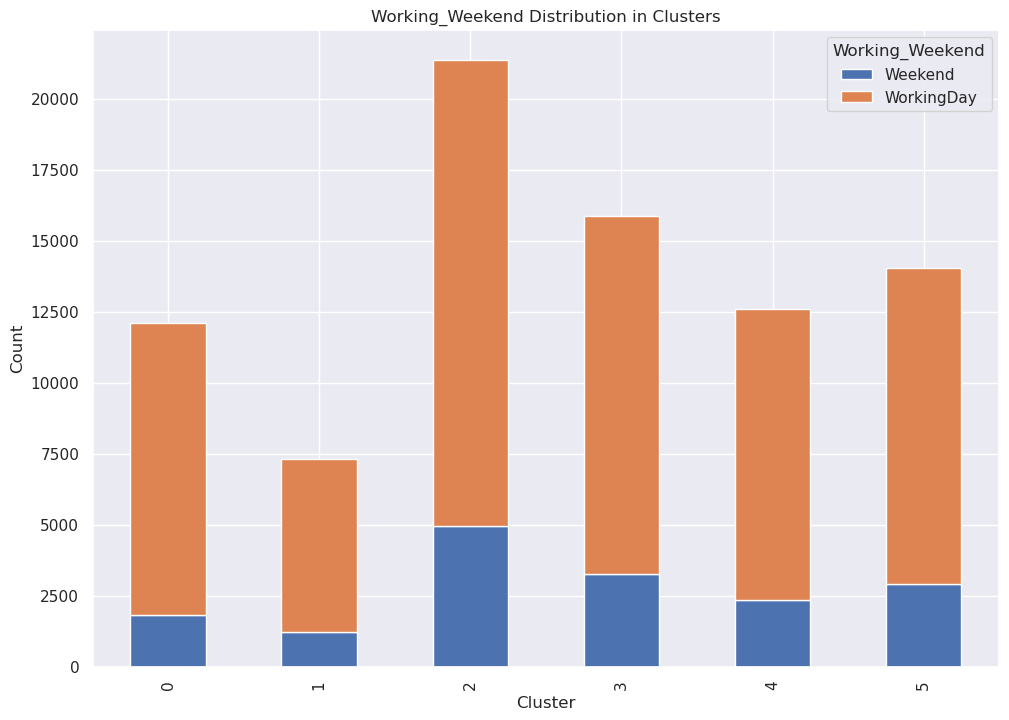

In [112]:
df_clusterbisecting_working=df
to_drop=['Start_Time','City','County','Wind_Direction','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal']
df_clusterbisecting_working=df_clusterbisecting_working.drop(*to_drop)

col = ['Distance_mi','Temperature_F','Humidity_perc','Visibility_mi','Wind_Speed_mph','Precipitation_in']

assembler = VectorAssembler(
    inputCols=col,
    outputCol="features")

output_dataset = assembler.transform(df_clusterbisecting_working)
scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")
output_dataset = scaler.fit(output_dataset).transform(output_dataset)
bisectingclusteringData_working= output_dataset.select("features_scaled", "Working_Weekend")

bisect_kmeans=BisectingKMeans(featuresCol="features_scaled",k=6)
model = bisect_kmeans.fit(bisectingclusteringData_working)
predictions = model.transform(bisectingclusteringData_working)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'Working_Weekend').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='Working_Weekend', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Working_Weekend Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()